In [1]:
import pandas as pd
import datetime as datetime
import matplotlib.pyplot as plt
import numpy as np
import spotpy
import time
import os
import tqdm as tqdm
import hydroanalysis
from utils.functions import find_max_unique_rows
from utils.functions import find_iterative_immediate_downstream

In [2]:
# Superflexpy things
from david2022 import FastReservoirPower, FastReservoirLinear
from superflexpy.framework.unit import Unit
from superflexpy.framework.node import Node
from superflexpy.framework.network import Network

from superflexpy.implementation.elements.hbv import UnsaturatedReservoir, PowerReservoir

from superflexpy.implementation.numerical_approximators.implicit_euler import ImplicitEulerPython
from superflexpy.implementation.root_finders.pegasus import PegasusPython

# Numba implementation:
from superflexpy.implementation.root_finders.pegasus import PegasusNumba
from superflexpy.implementation.numerical_approximators.implicit_euler import ImplicitEulerNumba

from superflexpy.implementation.elements.hbv import PowerReservoir
from superflexpy.framework.unit import Unit
from superflexpy.implementation.elements.thur_model_hess import SnowReservoir, UnsaturatedReservoir, PowerReservoir, HalfTriangularLag

from superflexpy.implementation.elements.structure_elements import Transparent, Junction, Splitter
from superflexpy.framework.element import ParameterizedElement

In [3]:
path_estreams = r'C:\Users\nascimth\Documents\Thiago\Eawag\Python\Scripts\estreams_part_b\data\EStreams'

In [4]:
# Read the dataset network
network_estreams = pd.read_csv(path_estreams+'\streamflow_gauges/estreams_gauging_stations.csv', encoding='utf-8')
network_estreams.set_index("basin_id", inplace = True)

# Convert 'date_column' and 'time_column' to datetime
network_estreams['start_date'] = pd.to_datetime(network_estreams['start_date'])
network_estreams['end_date'] = pd.to_datetime(network_estreams['end_date'])

# Convert to list both the nested_catchments and the duplicated_suspect columns
network_estreams['nested_catchments'] = network_estreams['nested_catchments'].apply(lambda x: x.strip("[]").replace("'", "").split(", "))

# Remove the brackets and handle NaN values
network_estreams['duplicated_suspect'] = network_estreams['duplicated_suspect'].apply(
    lambda x: x.strip("[]").replace("'", "").split(", ") if isinstance(x, str) else x)

# Set the nested catchments as a dataframe
nested_catchments = pd.DataFrame(network_estreams['nested_catchments'])

# Now we add the outlet to the list (IF it was not before):
# Ensure that the basin_id is in the nested_catchments
for basin_id in nested_catchments.index:
    if basin_id not in nested_catchments.at[basin_id, 'nested_catchments']:
        nested_catchments.at[basin_id, 'nested_catchments'].append(basin_id)

# Attributes already filtered previously:
#estreams_attributes = pd.read_csv('data/exploration/estreams_attributes_filtered_moselle_sm_su_tog.csv', encoding='utf-8')
estreams_attributes = pd.read_csv('../data/filtered_dataset/estreams_attributes_filtered_quality_geology_v01.csv', encoding='utf-8')

estreams_attributes.set_index("basin_id", inplace = True)

# Convert to list both the nested_catchments and the duplicated_suspect columns
estreams_attributes['nested_catchments'] = estreams_attributes['nested_catchments'].apply(lambda x: x.strip("[]").replace("'", "").split(", "))

# Remove the brackets and handle NaN values
estreams_attributes['duplicated_suspect'] = estreams_attributes['duplicated_suspect'].apply(
    lambda x: x.strip("[]").replace("'", "").split(", ") if isinstance(x, str) else x)

estreams_attributes.sort_index(inplace = True) 

In [5]:
# Geological attributes (regional scale)
geology_regional_31_classes_moselle = pd.read_csv("../data/estreams_geology_moselle_regional_attributes.csv", encoding='utf-8')

geology_regional_31_classes_moselle.set_index("basin_id", inplace = True)

# Create a dictionary to map permeability classes to corresponding columns
permeability_columns = {
    "high": ["lit_fra_Alluvium", 'lit_fra_Coal', 'lit_fra_Conglomerate', 'lit_fra_Gravel and sand',
             'lit_fra_Sand', 'lit_fra_Sand and gravel', 'lit_fra_Sandstone and conglomerate', 'lit_fra_Sandstone'
        ],
    
    "medium": ['lit_fra_Limestone', 'lit_fra_Sandstone and marl', 'lit_fra_Sandstone and schist',
              'lit_fra_Sandstone, conglomerate and marl',

              'lit_fra_Arkose', 'lit_fra_Dolomite rock', 'lit_fra_Limestone and marl', 'lit_fra_Marl', 
             'lit_fra_Marl and dolomite', 'lit_fra_Marl and limestone', 'lit_fra_Marl and sandstone',
               'lit_fra_Sandstone and siltstone', 'lit_fra_Sandstone, siltstone and schist', 
              'lit_fra_Schist and sandstone', 'lit_fra_Silt',  'lit_fra_Silt and schist', 'lit_fra_Siltstone, sandstone and schist'
              
             ],
    
    "low": ['lit_fra_Cristallin basement', 'lit_fra_Plutonic rock',  'lit_fra_Quarzite',
                    'lit_fra_Schist','lit_fra_Volcanic rock' 
                   ]
}

# Iterate over the permeability columns and calculate the area for each class
for permeability_class, columns in permeability_columns.items():
    geology_regional_31_classes_moselle[f'area_perm_{permeability_class}'] = geology_regional_31_classes_moselle[columns].sum(axis=1)

# Drop unnecessary columns
geology_regional_31_classes_moselle = geology_regional_31_classes_moselle[["area_perm_high", "area_perm_medium", "area_perm_low"]]

# Rename the columns
geology_regional_31_classes_moselle.columns = ["perm_high_regi", "perm_medium_regi", "perm_low_regi"]

# Display the updated DataFrame
geology_regional_31_classes_moselle

geology_regional_31_classes_moselle["baseflow_index"] = estreams_attributes["baseflow_index"]
geology_regional_31_classes_moselle.corr(method="pearson")

# Concatenation
estreams_attributes[["perm_high_regi", "perm_medium_regi", "perm_low_regi"]] = geology_regional_31_classes_moselle[["perm_high_regi", "perm_medium_regi", "perm_low_regi"]]

# Adjust the three categories for also global dataset
estreams_attributes["perm_high_glob2"] = estreams_attributes["perm_high_glob"]
estreams_attributes["perm_medium_glob2"] = estreams_attributes["perm_medium_glob"] + estreams_attributes["perm_low_glob"]
estreams_attributes["perm_low_glob2"] = estreams_attributes["perm_verylow_glob"]

###########################################################################################################################
# Adjust the columns of the dataset:
for basin_id in estreams_attributes.index.tolist():

    # Extract and divide by 100
    v1 = estreams_attributes.loc[basin_id, "perm_high_regi"] / 100
    v2 = estreams_attributes.loc[basin_id, "perm_medium_regi"] / 100
    v3 = estreams_attributes.loc[basin_id, "perm_low_regi"] / 100

    # Round all values to one decimal place
    v1 = round(v1, 2)
    v2 = round(v2, 2)
    v3 = round(v3, 2)

    # Ensure the sum is exactly 1 by adjusting the largest value
    diff = 1 - (v1 + v2 + v3)

    if diff != 0:
        # Adjust the value that was the largest before rounding
        if max(v1, v2, v3) == v1:
            v1 += diff
        elif max(v1, v2, v3) == v2:
            v2 += diff
        else:
            v3 += diff

    # Assign back
    estreams_attributes.loc[basin_id, "perm_high_regi"] = v1 * 100
    estreams_attributes.loc[basin_id, "perm_medium_regi"] = v2 * 100
    estreams_attributes.loc[basin_id, "perm_low_regi"] = v3 * 100


for basin_id in estreams_attributes.index.tolist():

    # Extract and divide by 100
    v1 = estreams_attributes.loc[basin_id, "perm_high_glob2"] / 100
    v2 = estreams_attributes.loc[basin_id, "perm_medium_glob2"] / 100
    v3 = estreams_attributes.loc[basin_id, "perm_low_glob2"] / 100

    # Round all values to one decimal place
    v1 = round(v1, 2)
    v2 = round(v2, 2)
    v3 = round(v3, 2)

    # Ensure the sum is exactly 1 by adjusting the largest value
    diff = 1 - (v1 + v2 + v3)

    if diff != 0:
        # Adjust the value that was the largest before rounding
        if max(v1, v2, v3) == v1:
            v1 += diff
        elif max(v1, v2, v3) == v2:
            v2 += diff
        else:
            v3 += diff

    # Assign back
    estreams_attributes.loc[basin_id, "perm_high_glob2"] = v1 * 100
    estreams_attributes.loc[basin_id, "perm_medium_glob2"] = v2 * 100
    estreams_attributes.loc[basin_id, "perm_low_glob2"] = v3 * 100

In [6]:
# Define the functions
def obj_fun_nsee(observations, simulation, expo=0.5):
    """
    Calculate the Normalized Squared Error Efficiency (NSEE) while ensuring that
    NaNs in simulation are NOT masked (only NaNs in observations are masked).

    Parameters:
        observations (array-like): Observed values (with fixed NaNs).
        simulation (array-like): Simulated values (can contain NaNs).
        expo (float, optional): Exponent applied to observations and simulations. Default is 1.0.

    Returns:
        float: NSEE score (higher values indicate worse performance).
    """
    observations = np.asarray(observations)
    simulation = np.asarray(simulation)

    # Mask only NaNs in observations
    mask = ~np.isnan(observations)
    obs = observations[mask]
    sim = simulation[mask]  # Keep all simulated values, even NaNs

    # If simulation contains NaNs after masking observations, return penalty
    if np.isnan(sim).any():
        return 10.0  # Large penalty if NaNs appear in the simulation

    metric = np.sum((sim**expo - obs**expo)**2) / np.sum((obs**expo - np.mean(obs**expo))**2)
    
    return float(metric)


def obj_fun_kge(observations, simulation):
    """
    Calculate the KGE-2012 objective function, ensuring that NaNs in simulation are NOT masked.
    
    Parameters:
        observations (array-like): Observed values (with fixed NaNs).
        simulation (array-like): Simulated values (can contain NaNs).

    Returns:
        float: KGE-2012 score (higher values indicate worse performance).
    """
    observations = np.asarray(observations)
    simulation = np.asarray(simulation)

    # Mask only NaNs in observations
    mask = ~np.isnan(observations)
    obs = observations[mask]
    sim = simulation[mask]  # Keep all simulated values, even NaNs

    # Check if there are NaNs in the simulation after masking obs
    if np.isnan(sim).any():
        return 10.0  # Large penalty if the simulation contains NaNs
    
    obs_mean = np.mean(obs)
    sim_mean = np.mean(sim)

    r = np.corrcoef(obs, sim)[0, 1]
    alpha = np.std(sim) / np.std(obs)
    beta = sim_mean / obs_mean

    kge = np.sqrt((r - 1)**2 + (alpha - 1)**2 + (beta - 1)**2)  # KGE-2012

    return float(kge)

In [7]:
# First we define the outlet of the Moselle to be used
outlets = ["DEBU1959"]
nested_cats_df = nested_catchments.loc[outlets, :]

# Now we save our dataframes in a dictionary of dataframes. One dataframe for each watershed. 

nested_cats_filtered = find_max_unique_rows(nested_cats_df)                                  # Filter only the catchemnts using the function stated before
nested_cats_filtered_df = nested_catchments.loc[nested_cats_filtered, :]                     # Here we filter the catchemnts for the list (again, after we apply our function):

# Store the variables for the selected catchments in a list of dataframes now for only the ones above 20 cats:
estreams_attributes_dfs = {}
for catchment in tqdm.tqdm(nested_cats_filtered):
    # Retrieve the nested list of catchments for the current catchment
    nested_clip = nested_cats_filtered_df.loc[catchment, 'nested_catchments']
    
    # Filter values to include only those that exist in the index of estreams_attributes
    nested_clip = [value for value in nested_clip if value in estreams_attributes.index]
    
    # Filter the estreams_attributes DataFrame based on the filtered nested_clip
    cat_clip = estreams_attributes.loc[nested_clip, :]
    
    # Store the resulting DataFrame in the dictionary
    estreams_attributes_dfs[catchment] = cat_clip

# Here we can save the length of each watershed (number of nested catchemnts)
catchment_lens = pd.DataFrame(index = estreams_attributes_dfs.keys())
for catchment, data in estreams_attributes_dfs.items():
    catchment_lens.loc[catchment, "len"] = len(data)

# Now we can filter it properly:
nested_cats_filtered_abovevalue = catchment_lens[catchment_lens.len >= 10]

# # Here we filter the catchemnts for the list (again, after we apply our function):
nested_cats_filtered_abovevalue_df = nested_catchments.loc[nested_cats_filtered_abovevalue.index, :]

# Store the variables for the selected catchments in a list of dataframes now for only the ones above 20 cats:
estreams_attributes_dfs = {}

for catchment in tqdm.tqdm(nested_cats_filtered_abovevalue_df.index):
    # Retrieve the nested list of catchments for the current catchment
    nested_clip = nested_cats_filtered_abovevalue_df.loc[catchment, 'nested_catchments']
    
    # Filter values to include only those that exist in the index of estreams_attributes
    nested_clip = [value for value in nested_clip if value in estreams_attributes.index]
    
    # Filter the estreams_attributes DataFrame based on the filtered nested_clip
    cat_clip = estreams_attributes.loc[nested_clip, :]
    
    # Store the resulting DataFrame in the dictionary
    estreams_attributes_dfs[catchment] = cat_clip

# Adjust and clip it:
estreams_attributes_clipped = estreams_attributes_dfs["DEBU1959"]

# Convert 'date_column' and 'time_column' to datetime
estreams_attributes_clipped['start_date'] = pd.to_datetime(estreams_attributes_clipped['start_date'])
estreams_attributes_clipped['end_date'] = pd.to_datetime(estreams_attributes_clipped['end_date'])


estreams_attributes_clipped_filters = estreams_attributes_clipped[estreams_attributes_clipped.end_date >= "2010"]
estreams_attributes_clipped_filters = estreams_attributes_clipped_filters[estreams_attributes_clipped_filters.start_date <= "2002"]

# Here we retrieve the conectivity (from EStreams computation)
# Load the nested catchments CSV file
df = pd.read_excel("../data/nested_catchments.xlsx")

# Rename columns for clarity
df = df.rename(columns={df.columns[1]: "basin_id", df.columns[2]: "connected_basin_id"})
df = df.drop(columns=[df.columns[0]])  # Drop the unnamed index column

100%|██████████| 1/1 [00:00<?, ?it/s]


In [8]:
catchments_ids = ["FR003237", # Epinal
                    "FR003249", # Toul
                    "FR003253", # Luneville
                    "FR000159", # Malzeville 
                    "FR003265", # Custines
                    "FR003271", # Nomeny
                    "FR000171", # Metz
                    "FR003272", # Hanconcourt
                    "FR003283", # Rosselange
                    "FR003275", # Boncourt
                    "DEBU1956", # Perl
                    "DEBU1957", #Fremersdorf
                    "FR003308", #Niedaltdorf
                    "FR003301", # Wittring
                    "FR003304", # Bliesbruck
                    "LU000007", #Ettelbruck
                    "DERP2004", # GemuendOur
                    "DERP2017", # Hentern
                    "DEBU1958", # Trier
                    "DERP2024", # Kordel
                    "DERP2033", # Plein
                    "DEBU1959", # Cochem
                    "DERP2011", #Alsdorf 
                    "DERP2003", # Bollendorf
                    "DERP2007"] # Pruem

catchments_ids = ["FR003237", # Epinal
                    "FR003249", # Toul
                    "FR000159", # Malzeville 
                    "FR003265", # Custines
                    "FR000171", # Metz
                    "FR003275", # Boncourt
                    "DEBU1956", # Perl
                    "FR003301", # Wittring
                    "LU000007", #Ettelbruck
                    "DERP2004", # GemuendOur
                    "DERP2024", # Kordel
                    "DEBU1959", # Cochem
                    "DERP2011"] #Alsdorf 

catchments_ids = ["DEBU1958", # Trier                    
                  "FR003272", # Hanconcourt
                  "DEBU1957", # Fremersdorf
                  "DERP2003", # Bollendorf
                  "FR003308", # Niedaltdorf
                  "FR003283", # Rosselange
                  "FR003253", # Luneville
                  "FR003271", # Nomeny
                  "DERP2033", # Plein
                  "DERP2017", # Hentern
                  "FR003304", # Bliesbruck
                  "DERP2007"] # Pruem

# Catchments used in the original Moselle paper (only)
catchments_ids = ["FR003237", # Epinal
                    "FR003249", # Toul
                    "FR003253", # Luneville
                    "FR000159", # Malzeville 
                    "FR003265", # Custines
                    "FR003271", # Nomeny
                    "FR000171", # Metz
                    "FR003272", # Hanconcourt
                    "FR003283", # Rosselange
                    "FR003275", # Boncourt
                    "DEBU1956", # Perl
                    "DEBU1957", #Fremersdorf
                    "FR003308", #Niedaltdorf
                    "FR003301", # Wittring
                    #"FR003304", # Bliesbruck
                    "LU000007", #Ettelbruck
                    "DERP2004", # GemuendOur
                    "DERP2017", # Hentern
                    "DEBU1958", # Trier
                    "DERP2024", # Kordel
                    "DERP2033", # Plein
                    "DEBU1959", # Cochem
                    "DERP2011", #Alsdorf 
                    "DERP2003", # Bollendorf
                    "DERP2007"] # Pruem
# Nalbach MISSING
# Reinheim MISSING

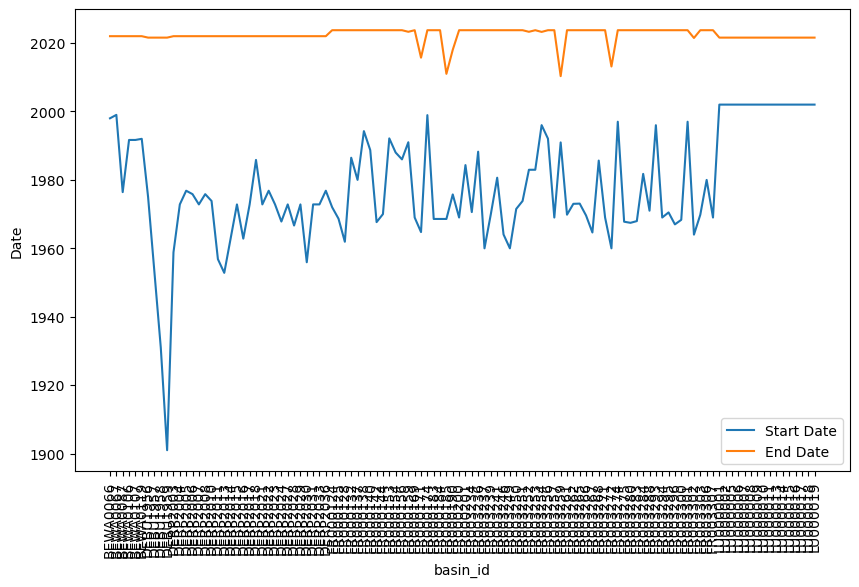

In [9]:
# Create figure and axis
fig, ax = plt.subplots(figsize=(10, 6))

# Plot start_date and end_date on the same graph
estreams_attributes_clipped_filters.start_date.plot(ax=ax, label="Start Date")
estreams_attributes_clipped_filters.end_date.plot(ax=ax, label="End Date")

# Make y-axis label vertical
ax.set_ylabel("Date", rotation=90)

# Ensure ALL x-axis ticks are shown
ax.set_xticks(np.arange(len(estreams_attributes_clipped_filters)))  # Set all x-ticks
ax.set_xticklabels(estreams_attributes_clipped_filters.index, rotation=90)  # Rotate labels

# Add legend
ax.legend()

# Show plot
plt.show()


In [10]:
#catchments_ids = estreams_attributes_clipped_filters.index.tolist()

In [11]:
estreams_attributes_clipped_filters_to_be_sorted = estreams_attributes.loc[catchments_ids, :]

# At this part we sort the values in order according to the area, and select the second as done in the Moselle paper originally. 
# Sort the DataFrame by 'area_estreams'
estreams_attributes_clipped_sorted = estreams_attributes_clipped_filters_to_be_sorted.sort_values(by='area_estreams')

# Select every second value (even index positions)
first_half_df = estreams_attributes_clipped_sorted.iloc[::2]

# Select the alternating second values (odd index positions)
second_half_df = estreams_attributes_clipped_sorted.iloc[1::2]

In [38]:
first_half_df = ['FR000184',
 'DERP2017',
 'DERP2011',
 'DERP2013',
 'DERP2007',
 'DERP2024',
 'FR003253',
 #'FR003308',
 'FR003283',
 'FR003301',
 'DERP2003',
 'FR003265',
 'FR003272',
 'DEBU1958']



second_half_df = ['FR003303',
 'FR000144',
 'DERP2033',
 'FR003275',
 'DERP2004',
 'FR003271',
 'LU000007',
 'FR003237',
 'FR000171',
 'FR000159',
 'FR003249',
 'DEBU1957',
 'DEBU1956',
 'DEBU1959']

In [39]:
#catchments_ids = first_half_df.index.tolist()
catchments_ids = first_half_df

#catchments_ids = second_half_df.index.tolist()
#catchments_ids = estreams_attributes_clipped_sorted.index.tolist()

# Run the iterative function
iterative_immediate_downstream = find_iterative_immediate_downstream(df, catchments_ids)

# Convert results to a DataFrame for display
iterative_downstream_df = pd.DataFrame(iterative_immediate_downstream.items(), 
                                       columns=['basin_id', 'immediate_downstream_basin'])


# Assuming the DataFrame has columns 'basin_id' and 'downstream_id'
topology_list = {basin: None for basin in catchments_ids}  # Default to None

# Filter DataFrame for relevant basin_ids and update topology
for _, row in iterative_downstream_df.iterrows():
    if row['basin_id'] in topology_list:
        topology_list[row['basin_id']] = row['immediate_downstream_basin']

topology_list

{'FR000184': 'FR003301',
 'DERP2017': None,
 'DERP2011': 'DEBU1958',
 'DERP2013': 'DEBU1958',
 'DERP2007': 'DEBU1958',
 'DERP2024': None,
 'FR003253': 'FR003265',
 'FR003283': 'DEBU1958',
 'FR003301': 'DEBU1958',
 'DERP2003': 'DEBU1958',
 'FR003265': 'FR003272',
 'FR003272': 'DEBU1958',
 'DEBU1958': None}

In [50]:
path_inputs = r'C:\Users\nascimth\Documents\Thiago\Eawag\Python\Scripts\estreams_superflexpy\data\models\input\subset_2001_2015'

inputs = np.load(path_inputs+'\\inputs.npy', allow_pickle=True).item()
observations = np.load(path_inputs+'\\observations.npy', allow_pickle=True).item()
areas = np.load(path_inputs+'\\areas.npy', allow_pickle=True).item()
perm_areas = np.load(path_inputs+'\\perm_areas.npy', allow_pickle=True).item()
perm_areasglobal = np.load(path_inputs+'\\perm_areasglobal.npy', allow_pickle=True).item()
quality_masks = np.load(path_inputs+'\\quality_masks.npy', allow_pickle=True).item()
rootdepth_mean = np.load(path_inputs+'\\rootdepth_mean.npy', allow_pickle=True).item()
waterdeficit_mean = np.load(path_inputs+'\\waterdeficit_mean.npy', allow_pickle=True).item()

In [48]:
path_inputs = r'C:\Users\nascimth\Documents\Thiago\Eawag\Python\Scripts\estreams_superflexpy\data\models\input\subset_1988_2001'

inputs = np.load(path_inputs+'//inputs.npy', allow_pickle=True).item()
observations = np.load(path_inputs+'//observations.npy', allow_pickle=True).item()
areas = np.load(path_inputs+'//areas.npy', allow_pickle=True).item()
perm_areas = np.load(path_inputs+'//perm_areas.npy', allow_pickle=True).item()
perm_areasglobal = np.load(path_inputs+'//perm_areasglobal.npy', allow_pickle=True).item()
perm_areascontinental = np.load(path_inputs+'//perm_areascontinental.npy', allow_pickle=True).item()
quality_masks = np.load(path_inputs+'//quality_masks.npy', allow_pickle=True).item()
rootdepth_mean = np.load(path_inputs+'//rootdepth_mean.npy', allow_pickle=True).item()
waterdeficit_mean = np.load(path_inputs+'//waterdeficit_mean.npy', allow_pickle=True).item()

In [49]:
waterdeficit_mean

{'BEWA0066': 289.8,
 'BEWA0067': 271.9,
 'BEWA0087': 331.1,
 'BEWA0106': 331.3,
 'BEWA0107': 287.8,
 'BEWA0119': 292.3,
 'DEBU1956': 471.7,
 'DEBU1957': 542.2,
 'DEBU1958': 464.6,
 'DEBU1959': 459.4,
 'DERP2003': 420.5,
 'DERP2004': 301.9,
 'DERP2005': 332.9,
 'DERP2006': 287.8,
 'DERP2007': 381.6,
 'DERP2008': 380.2,
 'DERP2010': 394.7,
 'DERP2011': 433.4,
 'DERP2013': 720.0,
 'DERP2014': 493.4,
 'DERP2015': 507.6,
 'DERP2016': 595.6,
 'DERP2017': 443.0,
 'DERP2018': 445.8,
 'DERP2021': 320.8,
 'DERP2022': 375.6,
 'DERP2023': 403.6,
 'DERP2024': 456.0,
 'DERP2027': 449.0,
 'DERP2028': 455.6,
 'DERP2029': 494.2,
 'DERP2030': 452.0,
 'DERP2031': 433.9,
 'DERP2033': 525.6,
 'DERP2036': 629.9,
 'FR000124': 193.8,
 'FR000125': 203.3,
 'FR000126': 206.4,
 'FR000127': 206.7,
 'FR000128': 237.0,
 'FR000132': 249.9,
 'FR000133': 278.0,
 'FR000134': 288.5,
 'FR000135': 336.2,
 'FR000136': 471.1,
 'FR000137': 461.6,
 'FR000138': 474.3,
 'FR000139': 474.3,
 'FR000140': 392.9,
 'FR000142': 291.8,


In [51]:
waterdeficit_mean

{'BEWA0066': 363.1,
 'BEWA0067': 318.3,
 'BEWA0087': 393.3,
 'BEWA0106': 471.2,
 'BEWA0107': 350.5,
 'BEWA0119': 373.1,
 'DEBU1956': 580.6,
 'DEBU1957': 863.5,
 'DEBU1958': 648.9,
 'DEBU1959': 631.6,
 'DERP2003': 528.9,
 'DERP2004': 408.0,
 'DERP2005': 467.0,
 'DERP2006': 351.0,
 'DERP2007': 464.3,
 'DERP2008': 487.0,
 'DERP2010': 449.2,
 'DERP2011': 515.4,
 'DERP2013': 878.7,
 'DERP2014': 805.4,
 'DERP2015': 840.4,
 'DERP2016': 916.5,
 'DERP2017': 415.6,
 'DERP2018': 419.3,
 'DERP2021': 351.6,
 'DERP2022': 374.3,
 'DERP2023': 391.0,
 'DERP2024': 442.2,
 'DERP2027': 412.3,
 'DERP2028': 450.6,
 'DERP2029': 559.5,
 'DERP2030': 497.9,
 'DERP2031': 420.2,
 'DERP2033': 777.2,
 'DERP2036': 1171.8,
 'FR000124': 308.7,
 'FR000125': 322.1,
 'FR000126': 325.1,
 'FR000127': 325.2,
 'FR000128': 359.1,
 'FR000132': 367.5,
 'FR000133': 406.1,
 'FR000134': 430.6,
 'FR000135': 473.2,
 'FR000136': 621.3,
 'FR000137': 598.8,
 'FR000138': 608.6,
 'FR000139': 608.6,
 'FR000140': 520.0,
 'FR000142': 437.8,

In [45]:
network_estreams.loc[second_half_df].iloc[:, 0:30].T

basin_id,FR003303,FR000144,DERP2033,FR003275,DERP2004,FR003271,LU000007,FR003237,FR000171,FR000159,FR003249,DEBU1957,DEBU1956,DEBU1959
gauge_id,A932215050,A623201001,2678060900,A807101001,2626030300,A782101001,42,A443064001,A788101001,A694102004,A573061001,26400550,26100100,26900400
gauge_name,L'Horn Ã Bousseviller,A6232010,Platten,L'Orne Ã Boncourt,GemuendOur,La Seille Ã Nomeny,EttelbrueckAlzette,La Moselle Ã Ã‰pinal,A7881010,A6941020,La Moselle Ã Toul,BundespegelFremersdorf,BundespegelPerl,BundespegelCochem
gauge_country,FR,FR,DE,FR,DE,FR,LU,FR,FR,FR,FR,DE,DE,DE
gauge_provider,FR_EAUFRANCE,FR_EAUFRANCE,DE_RP,FR_EAUFRANCE,DE_RP,FR_EAUFRANCE,LU_CONTACTFORM,FR_EAUFRANCE,FR_EAUFRANCE,FR_EAUFRANCE,FR_EAUFRANCE,DE_BU,DE_BU,DE_BU
river,L'Horn à Bousseviller,La Plaine à Raon-l'Étape [La Trouche],Lieser,L'Orne à Boncourt,Our,La Seille à Nomeny,Alzette,La Moselle à Épinal,La Seille à Metz,La Meurthe à Malzéville,La Moselle à Toul,Saar,Mosel,Mosel
lon_snap,7.472093,6.877879,6.954,5.830467,6.171,6.227788,6.098584,6.452981,6.188152,6.179269,5.896402,6.648,6.369,7.168
lat_snap,49.127103,48.41632,49.941,49.162566,49.985,48.888271,49.8448,48.165666,49.100774,48.710667,48.669764,49.409,49.473,50.143
lon,7.472093,6.877879,6.954,5.830467,6.171,6.227788,6.098584,6.452981,6.188152,6.179269,5.896402,6.648,6.369,7.168
lat,49.127103,48.41632,49.941,49.162566,49.985,48.888271,49.8448,48.165666,49.100774,48.710667,48.669764,49.409,49.473,50.143
elevation,265,290,NaN,185,NaN,181,NaN,324,163,188,201,NaN,NaN,NaN


In [42]:
root_finder = PegasusNumba()
num_app = ImplicitEulerNumba(root_finder=root_finder)

class ParameterizedSingleFluxSplitter(ParameterizedElement):
    _num_downstream = 2
    _num_upstream = 1
    
    def set_input(self, input):

        self.input = {'Q_in': input[0]}

    def get_output(self, solve=True):

        split_par = self._parameters[self._prefix_parameters + 'splitpar']

        output1 = [self.input['Q_in'] * split_par]
        output2 = [self.input['Q_in'] * (1 - split_par)]
        
        return [output1, output2]   
    
    
lower_splitter = ParameterizedSingleFluxSplitter(
    parameters={'splitpar': 0.5},
    id='lowersplitter'
)

lower_splitter_medium = ParameterizedSingleFluxSplitter(
    parameters={'splitpar': 0.6},
    id='lowersplitter'
)

lower_splitter_high = ParameterizedSingleFluxSplitter(
    parameters={'splitpar': 0.7},
    id='lowersplitter'
)

# Fluxes in the order P, T, PET
upper_splitter = Splitter(
    direction=[
        [0, 1, None],    # P and T go to the snow reservoir
        [2, None, None]  # PET goes to the transparent element
    ],
    weight=[
        [1.0, 1.0, 0.0],
        [0.0, 0.0, 1.0]
    ],
    id='upper-splitter'
)

snow = SnowReservoir(
    parameters={'t0': 0.0, 'k': 0.01, 'm': 2.0},
    states={'S0': 0.0},
    approximation=num_app,
    id='snow'
)

upper_transparent = Transparent(
    id='upper-transparent'
)

upper_junction = Junction(
    direction=[
        [0, None],
        [None, 0]
    ],
    id='upper-junction'
)


unsaturated = UnsaturatedReservoir(
    parameters={'Smax': 150.0, 'Ce': 1.0, 'm': 0.01, 'beta': 2.0},
    states={'S0': 10.0},
    approximation=num_app,
    id='unsaturated'
)

fast = PowerReservoir(
    parameters={'k': 0.01, 'alpha': 2.0},
    states={'S0': 0.0},
    approximation=num_app,
    id='fast'
)

slow = PowerReservoir(
    parameters={'k': 1e-4, 'alpha': 1.0},
    states={'S0': 0.0},
    approximation=num_app,
    id='slow'
)

slowhigh = PowerReservoir(
    parameters={'k': 1e-4, 'alpha': 2.0},
    states={'S0': 0.0},
    approximation=num_app,
    id='slowhigh'
)


lower_junction = Junction(
    direction=[
        [0, 0]
    ],
    id='lower-junction'
)

lag_fun = HalfTriangularLag(
    parameters={'lag-time': 4.0},
    states={'lag': None},
    id='lag-fun'
)

lower_transparent = Transparent(
    id='lower-transparent'
)

lower_transparent2 = Transparent(
    id='lower-transparent2'
)

general = Unit(
    layers=[
        [upper_splitter],
        [snow, upper_transparent],
        [upper_junction],
        [unsaturated],
        [lower_splitter],
        [slow, lag_fun],
        [lower_transparent, fast],
        [lower_junction],
    ],
    id='general'
)

low = Unit(
    layers=[
        [upper_splitter],
        [snow, upper_transparent],
        [upper_junction],
        [unsaturated],
        [fast],
    ],
    id='low'
)

high = Unit(
    layers=[
        [upper_splitter],
        [snow, upper_transparent],
        [upper_junction],
        [unsaturated],
        [slowhigh],
    ],
    id='high'
)


# Generate Nodes dynamically and assign them as global variables
catchments = [] # Dictionary to store nodes

for cat_id in catchments_ids:
    node = Node(
        units=[high, general, low],  # Use unit from dictionary or default
        weights=perm_areasglobal[cat_id],
        area=areas.get(cat_id),  # Use predefined area or default
        id=cat_id
    )
    catchments.append(node)  # Store in the list

    # Assign the node as a global variable
    globals()[cat_id] = node

# Ensure topology only includes nodes that exist in `catchments_ids`
topology = {
    cat_id: upstream if upstream in catchments_ids else None
    for cat_id, upstream in topology_list.items() if cat_id in catchments_ids
}

# Create the Network
model = Network(
    nodes=catchments,  # Pass list of Node objects
    topology=topology  
)


# Set inputs for each node using the manually defined dictionary
for cat in catchments:
    cat.set_input(inputs[cat.id])  # Correct way to set inputs



In [43]:
def assign_parameter_values(parameters_name_model, parameter_names, parameters):
    """
    Assigns values from `parameters` to `parameters_name_model` where a match exists in `parameter_names`,
    but keeps any parameters that have three segments (`X_Y_Z`) unchanged.

    Args:
        parameters_name_model (list): List of full parameter names (e.g., "general_slow_k").
        parameter_names (list): List of unique parameter names (e.g., "slow_k", "high_slow_k").
        parameters (list): List of values corresponding to `parameter_names`.

    Returns:
        dict: Dictionary {parameter_name_model: assigned_value}, where:
            - `X_Y` parameters are updated from `parameter_names`.
            - `X_Y_Z` parameters are kept unchanged.
    """
    # Create a dictionary mapping parameter_names to their corresponding values
    param_value_dict = {param_name: value for param_name, value in zip(parameter_names, parameters)}

    # Build the output dictionary
    filtered_parameters = {}

    for param_name in parameters_name_model:
        parts = param_name.split("_")  # Split the name to check structure
        base_name = "_".join(parts[-2:])  # Extract last two parts (X_Y)
        
        if base_name in param_value_dict:  # If X_Y is in parameter_names
            filtered_parameters[param_name] = param_value_dict[base_name]
        elif param_name in parameter_names:  # Direct match in parameter_names (X_Y)
            filtered_parameters[param_name] = param_value_dict[param_name]
    
    return filtered_parameters  # Return dictionary of matched parameters


class spotpy_model(object):

    def __init__(self, model, catchments, dt, observations, parameters, parameter_names, parameter_names_model, output_index, warm_up=365):

        """
        Spotpy model for multi-node calibration in SuperflexPy.

        Args:
            model (Network): SuperflexPy network containing multiple nodes.
            catchments (list): List of Node objects.
            inputs (dict): Dictionary with inputs for each node.
            dt (float): Time step.
            observations (dict): Observed discharge data for each node.
            parameters (list): List of parameter distributions for calibration.
            parameter_names (list): Names of the parameters.
            output_index (str/int): The output key for extracting model results.
            warm_up (int): Number of time steps to ignore in the evaluation.
        """
        self._model = model  # The SuperflexPy network
        self._catchments = catchments  # List of catchments
        self._dt = dt  # Time step

        # Store shared calibration parameters
        self._parameters = parameters
        self._parameter_names = parameter_names
        self._parameter_names_model = parameter_names_model  # Store full parameter names

        # Store inputs and observations for each node
        self._observations = observations  # Dictionary {node_id: observed_data}
        self._output_index = output_index  # Output key (e.g., 'Q_out')
        self._warm_up = int(warm_up)  # Warm-up period

    def parameters(self):
        """Generate parameter samples for calibration."""
        return spotpy.parameter.generate(self._parameters)

    def simulation(self, parameters):
        """Runs the entire network using the same parameter set and collects per-node outputs."""

        # Convert parameter list into a dictionary
        #named_parameters = assign_parameter_values(self._parameter_names_model, self._parameter_names, parameters)
        
        # Check if parameters have changed (avoid unnecessary computations)
        if not hasattr(self, "_cached_params") or not np.array_equal(self._cached_params, parameters):
            self._cached_params = np.array(parameters)  # Store the current parameters
            named_parameters = assign_parameter_values(self._parameter_names_model, self._parameter_names, parameters)
            self._model.set_parameters(named_parameters)  # Apply shared parameters

        # Ensure `named_parameters` is always defined
        #named_parameters = None  

        ## Check if parameters have changed (avoid unnecessary computations)
        #if not hasattr(self, "_cached_params") or not np.array_equal(self._cached_params, parameters):
        #    self._cached_params = np.array(parameters)  # Store the current parameters
        #    named_parameters = assign_parameter_values(self._parameter_names_model, self._parameter_names, parameters)
        #    self._cached_named_parameters = named_parameters  # Cache the named parameters
        #    self._model.set_parameters(named_parameters)  # Apply shared parameters
        #else:
        #    named_parameters = self._cached_named_parameters  # Retrieve from cache

        # Apply shared parameters to the whole network
        self._model.set_parameters(named_parameters)

        # Set timestep and reset the network
        self._model.set_timestep(self._dt)
        self._model.reset_states()

        # Run the full network
        output = self._model.get_output()  # Get outputs for all nodes

        # Return outputs as a list (one per node)
        return [output[cat.id][self._output_index] for cat in self._catchments]

    def evaluation(self):
        """Returns the observed data for all nodes."""
        return self._observations

    def objectivefunction(self, simulation, evaluation):
        """Computes the average NSE (or another metric) across all nodes."""

        obj_values = []  # Store individual NSE values for each node

        for sim, cat in zip(simulation, self._catchments):
            node_id = cat.id
            obs = evaluation[node_id]

            # Apply warm-up period
            sim = sim[self._warm_up + 1:]
            obs = obs[self._warm_up + 1:]

            # Compute NSE (or another metric like KGE)
            obj_value = obj_fun_nsee(observations=obs, simulation=sim, expo=0.5)
            obj_values.append(obj_value)

        # Compute the average objective function across all nodes
        return np.mean(obj_values)  # Minimize the average error

model.reset_states()

spotpy_hyd_mod = spotpy_model(
    model=model,  # The entire SuperflexPy network
    catchments=catchments,  # Use predefined catchments list
    dt=1.0,  # Time step
    observations=observations,  # Observed data per node
    parameters=[
        spotpy.parameter.Uniform("general_fast_k", 0.0001, 1.0), #1e-5, 1.0
        spotpy.parameter.Uniform("low_fast_k", 0.0001, 1.0),

        spotpy.parameter.Uniform("high_slowhigh_k", 1e-7, 0.1),
        spotpy.parameter.Uniform("general_slow_k", 1e-7, 0.1),

        spotpy.parameter.Uniform("unsaturated_Ce", 0.1, 3.0),
        spotpy.parameter.Uniform("snow_k", 0.01, 10.0),
        spotpy.parameter.Uniform("unsaturated_Smax", 100.0, 600.0),
        spotpy.parameter.Uniform("splitpar", 0.5, 0.9),
        spotpy.parameter.Uniform("unsaturated_beta", 0.01, 10.0),
        spotpy.parameter.Uniform("lag-fun_lag-time", 1.0, 10.0),
    ],
    parameter_names=[
        "general_fast_k", "low_fast_k", 
        "high_slowhigh_k", "general_slow_k", "unsaturated_Ce", "snow_k", "unsaturated_Smax", "splitpar",
        "unsaturated_beta", "lag-fun_lag-time",
    ],
    parameter_names_model = model.get_parameters_name(),
    output_index=0,  # Assumes all nodes have the same output variable
    warm_up=365  # Warm-up period
)

#parameter_names_model = model.get_parameters_name()

In [44]:
#sampler = spotpy.algorithms.sceua(spotpy_hyd_mod, dbname=None, dbformat='ram')
sampler = spotpy.algorithms.sceua(spotpy_hyd_mod, dbname='calibration', dbformat="csv", parallel="seq")

sampler.sample(repetitions=50000)

Initializing the  Shuffled Complex Evolution (SCE-UA) algorithm  with  50000  repetitions
The objective function will be minimized
Starting burn-in sampling...
Initialize database...
['csv', 'hdf5', 'ram', 'sql', 'custom', 'noData']
* Database file 'calibration.csv' created.
3 of 50000, minimal objective function=2.2031, time remaining: 08:22:19
6 of 50000, minimal objective function=2.1059, time remaining: 09:45:54
9 of 50000, minimal objective function=0.902015, time remaining: 10:11:20
12 of 50000, minimal objective function=0.902015, time remaining: 10:26:59


KeyboardInterrupt: 

In [ ]:
# Load the CSV file
results_df = pd.read_csv("calibration.csv")


# Convert to a NumPy structured array (similar to `sampler.getdata()`)
results = results_df.to_records(index=False)

In [ ]:
#results = sampler.getdata()                                                  # Load the results
spotpy.analyser.plot_parametertrace(results)                                 # Show the results


bestindex, bestobjf = spotpy.analyser.get_minlikeindex(results)               # Get the best indexes and objective function


spotpy.analyser.get_parameters(results)[bestindex]

best_params_dict = dict(zip(spotpy.analyser.get_parameternames(results), spotpy.analyser.get_parameters(results)[bestindex]))


if 'splitpar' in best_params_dict:
    best_params_dict['general_lowersplitter_splitpar'] = best_params_dict.pop('splitpar')

if 'M4_lagfun_lagtime' in best_params_dict:
    best_params_dict['M4_lag-fun_lag-time'] = best_params_dict.pop('M4_lagfun_lagtime')


# Remove spaces and replace with underscores (or any other transformation)
best_params_dict = {key.replace(" ", ""): value for key, value in best_params_dict.items()}

In [ ]:
best_params_dict

In [ ]:
parameter_names = list(best_params_dict.keys())
parameters = list(best_params_dict.values())
parameter_names_model = model.get_parameters_name()
best_params_dict_model = assign_parameter_values(parameter_names_model, parameter_names, parameters)
best_params_dict_model

In [ ]:
best_params_dict_model_r_1 = {'high_snow_k': 4.086426297944429,
 'high_unsaturated_Ce': 0.9567288089362507,
 'high_unsaturated_beta': 1.0331337523819135,
 'high_slowhigh_k': 0.0013319218103794586,
 'general_snow_k': 4.086426297944429,
 'general_unsaturated_Ce': 0.9567288089362507,
 'general_unsaturated_beta': 1.0331337523819135,
 'general_slow_k': 0.011234798028853129,
 'general_lag-fun_lag-time': 3.9750011064022424,
 'general_fast_k': 0.48590540089635903,
 'low_snow_k': 4.086426297944429,
 'low_unsaturated_Ce': 0.9567288089362507,
 'low_unsaturated_beta': 1.0331337523819135,
 'low_fast_k': 0.004905033249936297}

In [ ]:
best_params_dict_model_g_1 = {'high_snow_k': 4.196749756267835,
 'high_unsaturated_Ce': 0.8669048058401205,
 'high_unsaturated_beta': 0.8923904812427841,
 'high_slowhigh_k': 0.0009871387474522922,
 'general_snow_k': 4.196749756267835,
 'general_unsaturated_Ce': 0.8669048058401205,
 'general_unsaturated_beta': 0.8923904812427841,
 'general_slow_k': 0.024640353857886783,
 'general_lag-fun_lag-time': 3.175523750291455,
 'general_fast_k': 0.25928255610147044,
 'low_snow_k': 4.196749756267835,
 'low_unsaturated_Ce': 0.8669048058401205,
 'low_unsaturated_beta': 0.8923904812427841,
 'low_fast_k': 0.16955621942568638}

In [ ]:
best_params_dict_model_r_1_Sumax = {'high_snow_k': 4.827621,
 'high_unsaturated_Smax': 135.82315,
 'high_unsaturated_Ce': 0.7436071,
 'high_unsaturated_beta': 1.3400413,
 'high_slowhigh_k': 0.00022118725,
 'general_snow_k': 4.827621,
 'general_unsaturated_Smax': 135.82315,
 'general_unsaturated_Ce': 0.7436071,
 'general_unsaturated_beta': 1.3400413,
 'general_slow_k': 0.04206265,
 'general_lag-fun_lag-time': 3.6903367,
 'general_fast_k': 0.48363513,
 'low_snow_k': 4.827621,
 'low_unsaturated_Smax': 135.82315,
 'low_unsaturated_Ce': 0.7436071,
 'low_unsaturated_beta': 1.3400413,
 'low_fast_k': 0.0070152953}

In [ ]:
best_params_dict_model_r_1_SumaxD = {'high_snow_k': 2.8131618,
 'high_unsaturated_Smax': 115.87451,
 'high_unsaturated_Ce': 0.77449185,
 'high_unsaturated_beta': 1.6093758,
 'high_slowhigh_k': 3.0406694e-05,
 'general_snow_k': 2.8131618,
 'general_unsaturated_Smax': 115.87451,
 'general_unsaturated_Ce': 0.77449185,
 'general_unsaturated_beta': 1.6093758,
 'general_lowersplitter_splitpar': 0.7289779,
 'general_slow_k': 0.07241783,
 'general_lag-fun_lag-time': 3.040764,
 'general_fast_k': 0.14148608,
 'low_snow_k': 2.8131618,
 'low_unsaturated_Smax': 115.87451,
 'low_unsaturated_Ce': 0.77449185,
 'low_unsaturated_beta': 1.6093758,
 'low_fast_k': 0.0048795976}

In [ ]:
best_params_dict_model_g_1_SumaxD = {'high_snow_k': 2.934993580860046,
 'high_unsaturated_Smax': 127.23002055688586,
 'high_unsaturated_Ce': 0.8032976193402295,
 'high_unsaturated_beta': 1.2176739587191074,
 'high_slowhigh_k': 3.0406694e-05,
 'general_snow_k': 2.934993580860046,
 'general_unsaturated_Smax': 127.23002055688586,
 'general_unsaturated_Ce': 0.8032976193402295,
 'general_unsaturated_beta': 1.2176739587191074,
 'general_lowersplitter_splitpar': 0.7510347309521164,
 'general_slow_k': 0.09993578628220479,
 'general_lag-fun_lag-time': 2.8801273144273436,
 'general_fast_k': 0.12130750321170947,
 'low_snow_k': 2.934993580860046,
 'low_unsaturated_Smax': 127.23002055688586,
 'low_unsaturated_Ce': 0.8032976193402295,
 'low_unsaturated_beta': 1.2176739587191074,
 'low_fast_k': 0.0016403798882305785}

In [ ]:
best_params_dict_model = best_params_dict_model_g_1_SumaxD

In [ ]:
model.reset_states()

# Set inputs for each node using the manually defined dictionary
for cat in catchments:
    cat.set_input(inputs[cat.id])  # Correct way to set inputs

model.set_timestep(1.0)

model.set_parameters(best_params_dict_model)

#hyd_mod.reset_states()
output = model.get_output()
output

In [ ]:
# Create an empty list to store results
nse_results_cal = []

for basin in catchments_ids:
    Qtimeseries = pd.DataFrame(index=pd.date_range('2002-01-01', '2014-12-31', freq='D'))
    Qtimeseries["Qobs"] = observations[basin]
    Qtimeseries["Qcalc"] = output[basin][0]

    nse_value = 1 - obj_fun_nsee(observations=Qtimeseries.iloc[365:, 0].values, 
                                 simulation=Qtimeseries.iloc[365:, 1].values, 
                                 expo=0.5)
    
    mean_q_obs = np.nanmean(Qtimeseries.iloc[365:, 0].values)  
    mean_q_calc = np.nanmean(Qtimeseries.iloc[365:, 1].values) 
    bfi_obs = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=False)
    bfi_sim = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 1].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=False)
    
    try:
        bfi_obs_series = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1]
        
        nse_value_bfi = 1 - obj_fun_nsee(observations=hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1], 
                                 simulation=hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 1].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1], 
                                 expo=0.5)
    except:
        nse_value_bfi = np.nan


    nse_results_cal.append({
        "gauge_name": network_estreams.loc[basin, "gauge_name"],
        "basin": basin,
        "nse": nse_value,
        "q_mean_obs": mean_q_obs,
        "q_mean_calc": mean_q_calc,
        "bfi_obs": bfi_obs,
        "bfi_sim":bfi_sim,
        "nse_value_bfi": nse_value_bfi
        })

# Convert results to DataFrame
nse_results_cal_g_1_56 = pd.DataFrame(nse_results_cal)
nse_results_cal_g_1_56

In [ ]:
# Create an empty list to store results
nse_results_cal = []

for basin in catchments_ids:
    Qtimeseries = pd.DataFrame(index=pd.date_range('1988-01-01', '2001-12-31', freq='D'))
    Qtimeseries["Qobs"] = observations[basin]
    Qtimeseries["Qcalc"] = output[basin][0]

    nse_value = 1 - obj_fun_nsee(observations=Qtimeseries.iloc[365:, 0].values, 
                                 simulation=Qtimeseries.iloc[365:, 1].values, 
                                 expo=0.5)
    
    mean_q_obs = np.nanmean(Qtimeseries.iloc[365:, 0].values)  
    mean_q_calc = np.nanmean(Qtimeseries.iloc[365:, 1].values) 
    bfi_obs = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=False)
    bfi_sim = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 1].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=False)
    
    try:
        bfi_obs_series = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1]
        
        nse_value_bfi = 1 - obj_fun_nsee(observations=hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1], 
                                 simulation=hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 1].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1], 
                                 expo=0.5)
    except:
        nse_value_bfi = np.nan


    nse_results_cal.append({
        "gauge_name": network_estreams.loc[basin, "gauge_name"],
        "basin": basin,
        "nse": nse_value,
        "q_mean_obs": mean_q_obs,
        "q_mean_calc": mean_q_calc,
        "bfi_obs": bfi_obs,
        "bfi_sim":bfi_sim,
        "nse_value_bfi": nse_value_bfi
        })

# Convert results to DataFrame
nse_results_cal_g_1_56 = pd.DataFrame(nse_results_cal)
nse_results_cal_g_1_56

In [ ]:
nse_results_cal_g_1_56.corr()


In [ ]:
# Create an empty list to store results
nse_results_cal = []

for basin in catchments_ids:
    Qtimeseries = pd.DataFrame(index=pd.date_range('2002-01-01', '2014-12-31', freq='D'))
    Qtimeseries["Qobs"] = observations[basin]
    Qtimeseries["Qcalc"] = output[basin][0]

    nse_value = 1 - obj_fun_nsee(observations=Qtimeseries.iloc[365:, 0].values, 
                                 simulation=Qtimeseries.iloc[365:, 1].values, 
                                 expo=0.5)
    
    mean_q_obs = np.nanmean(Qtimeseries.iloc[365:, 0].values)  
    mean_q_calc = np.nanmean(Qtimeseries.iloc[365:, 1].values) 
    bfi_obs = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=False)
    bfi_sim = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 1].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=False)
    
    try:
        bfi_obs_series = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1]
        
        nse_value_bfi = 1 - obj_fun_nsee(observations=hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1], 
                                 simulation=hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 1].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1], 
                                 expo=0.5)
    except:
        nse_value_bfi = np.nan


    nse_results_cal.append({
        "gauge_name": network_estreams.loc[basin, "gauge_name"],
        "basin": basin,
        "nse": nse_value,
        "q_mean_obs": mean_q_obs,
        "q_mean_calc": mean_q_calc,
        "bfi_obs": bfi_obs,
        "bfi_sim":bfi_sim,
        "nse_value_bfi": nse_value_bfi
        })

# Convert results to DataFrame
nse_results_cal_r_1_56 = pd.DataFrame(nse_results_cal)
nse_results_cal_r_1_56

In [ ]:
# Create an empty list to store results
nse_results_cal = []

for basin in catchments_ids:
    Qtimeseries = pd.DataFrame(index=pd.date_range('2002-01-01', '2014-12-31', freq='D'))
    Qtimeseries["Qobs"] = observations[basin]
    Qtimeseries["Qcalc"] = output[basin][0]

    nse_value = 1 - obj_fun_nsee(observations=Qtimeseries.iloc[365:, 0].values, 
                                 simulation=Qtimeseries.iloc[365:, 1].values, 
                                 expo=0.5)
    
    mean_q_obs = np.nanmean(Qtimeseries.iloc[365:, 0].values)  
    mean_q_calc = np.nanmean(Qtimeseries.iloc[365:, 1].values) 
    bfi_obs = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=False)
    bfi_sim = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 1].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=False)

    nse_results_cal.append({
        "gauge_name": network_estreams.loc[basin, "gauge_name"],
        "basin": basin,
        "nse": nse_value,
        "q_mean_obs": mean_q_obs,
        "q_mean_calc": mean_q_calc,
        "bfi_obs": bfi_obs,
        "bfi_sim":bfi_sim,
        })

# Convert results to DataFrame
nse_results_cal_g_1 = pd.DataFrame(nse_results_cal)
nse_results_cal_g_1

In [ ]:
# Create an empty list to store results
nse_results_cal = []

for basin in catchments_ids:
    Qtimeseries = pd.DataFrame(index=pd.date_range('2002-01-01', '2014-12-31', freq='D'))
    Qtimeseries["Qobs"] = observations[basin]
    Qtimeseries["Qcalc"] = output[basin][0]

    nse_value = 1 - obj_fun_nsee(observations=Qtimeseries.iloc[365:, 0].values, 
                                 simulation=Qtimeseries.iloc[365:, 1].values, 
                                 expo=0.5)
    
    mean_q_obs = np.nanmean(Qtimeseries.iloc[365:, 0].values)  
    mean_q_calc = np.nanmean(Qtimeseries.iloc[365:, 1].values) 
    bfi_obs = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=False)
    bfi_sim = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 1].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=False)
    
    try:
        bfi_obs_series = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1]
        
        nse_value_bfi = 1 - obj_fun_nsee(observations=hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1], 
                                 simulation=hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 1].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1], 
                                 expo=0.5)
    except:
        nse_value_bfi = np.nan


    nse_results_cal.append({
        "gauge_name": network_estreams.loc[basin, "gauge_name"],
        "basin": basin,
        "nse": nse_value,
        "q_mean_obs": mean_q_obs,
        "q_mean_calc": mean_q_calc,
        "bfi_obs": bfi_obs,
        "bfi_sim":bfi_sim,
        "nse_value_bfi": nse_value_bfi
        })

# Convert results to DataFrame
nse_results_cal_g_1 = pd.DataFrame(nse_results_cal)
nse_results_cal_g_1

In [ ]:
# Create an empty list to store results
nse_results_cal = []

for basin in catchments_ids:
    Qtimeseries = pd.DataFrame(index=pd.date_range('2002-01-01', '2014-12-31', freq='D'))
    Qtimeseries["Qobs"] = observations[basin]
    Qtimeseries["Qcalc"] = output[basin][0]

    nse_value = 1 - obj_fun_nsee(observations=Qtimeseries.iloc[365:, 0].values, 
                                 simulation=Qtimeseries.iloc[365:, 1].values, 
                                 expo=0.5)
    
    mean_q_obs = np.nanmean(Qtimeseries.iloc[365:, 0].values)  
    mean_q_calc = np.nanmean(Qtimeseries.iloc[365:, 1].values) 
    bfi_obs = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=False)
    bfi_sim = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 1].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=False)
    
    try:
        bfi_obs_series = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1]
        
        nse_value_bfi = 1 - obj_fun_nsee(observations=hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1], 
                                 simulation=hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 1].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1], 
                                 expo=0.5)
    except:
        nse_value_bfi = np.nan


    nse_results_cal.append({
        "gauge_name": network_estreams.loc[basin, "gauge_name"],
        "basin": basin,
        "nse": nse_value,
        "q_mean_obs": mean_q_obs,
        "q_mean_calc": mean_q_calc,
        "bfi_obs": bfi_obs,
        "bfi_sim":bfi_sim,
        "nse_value_bfi": nse_value_bfi
        })

# Convert results to DataFrame
nse_results_cal_r_1 = pd.DataFrame(nse_results_cal)
nse_results_cal_r_1

In [ ]:
# Create an empty list to store results
nse_results_cal = []

for basin in catchments_ids:
    Qtimeseries = pd.DataFrame(index=pd.date_range('2002-01-01', '2014-12-31', freq='D'))
    Qtimeseries["Qobs"] = observations[basin]
    Qtimeseries["Qcalc"] = output[basin][0]

    nse_value = 1 - obj_fun_nsee(observations=Qtimeseries.iloc[365:, 0].values, 
                                 simulation=Qtimeseries.iloc[365:, 1].values, 
                                 expo=0.5)
    
    mean_q_obs = np.nanmean(Qtimeseries.iloc[365:, 0].values)  
    mean_q_calc = np.nanmean(Qtimeseries.iloc[365:, 1].values) 
    bfi_obs = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=False)
    bfi_sim = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 1].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=False)
    
    try:
        bfi_obs_series = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1]
        
        nse_value_bfi = 1 - obj_fun_nsee(observations=hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1], 
                                 simulation=hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 1].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1], 
                                 expo=0.5)
    except:
        nse_value_bfi = np.nan


    nse_results_cal.append({
        "gauge_name": network_estreams.loc[basin, "gauge_name"],
        "basin": basin,
        "nse": nse_value,
        "q_mean_obs": mean_q_obs,
        "q_mean_calc": mean_q_calc,
        "bfi_obs": bfi_obs,
        "bfi_sim":bfi_sim,
        "nse_value_bfi": nse_value_bfi
        })

# Convert results to DataFrame
nse_results_cal_r_1 = pd.DataFrame(nse_results_cal)
nse_results_cal_r_1

In [ ]:
# Create an empty list to store results
nse_results_cal = []

for basin in catchments_ids:
    Qtimeseries = pd.DataFrame(index=pd.date_range('2002-01-01', '2014-12-31', freq='D'))
    Qtimeseries["Qobs"] = observations[basin]
    Qtimeseries["Qcalc"] = output[basin][0]

    nse_value = 1 - obj_fun_nsee(observations=Qtimeseries.iloc[365:, 0].values, 
                                 simulation=Qtimeseries.iloc[365:, 1].values, 
                                 expo=0.5)
    
    mean_q_obs = np.nanmean(Qtimeseries.iloc[365:, 0].values)  
    mean_q_calc = np.nanmean(Qtimeseries.iloc[365:, 1].values) 
    bfi_obs = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=False)
    bfi_sim = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 1].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=False)
    
    try:
        bfi_obs_series = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1]
        
        nse_value_bfi = 1 - obj_fun_nsee(observations=hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1], 
                                 simulation=hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 1].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1], 
                                 expo=0.5)
    except:
        nse_value_bfi = np.nan


    nse_results_cal.append({
        "gauge_name": network_estreams.loc[basin, "gauge_name"],
        "basin": basin,
        "nse": nse_value,
        "q_mean_obs": mean_q_obs,
        "q_mean_calc": mean_q_calc,
        "bfi_obs": bfi_obs,
        "bfi_sim":bfi_sim,
        "nse_value_bfi": nse_value_bfi
        })

# Convert results to DataFrame
nse_results_cal_r_1 = pd.DataFrame(nse_results_cal)
nse_results_cal_r_1

In [ ]:
nse_results_cal_r_1.corr()

In [ ]:
# Create scatter plot
plt.scatter(nse_results_cal_r_1["bfi_obs"], nse_results_cal_r_1["bfi_sim"], alpha=0.6)
# Set limits (adjust according to your data range)
plt.xlim([0.2, 1])
plt.ylim([0.2, 1])


In [ ]:
# Create scatter plot
plt.scatter(nse_results_cal_g_1_56["bfi_obs"], nse_results_cal_g_1_56["bfi_sim"], alpha=0.6)
# Set limits (adjust according to your data range)
plt.xlim([0.2, 1])
plt.ylim([0.2, 1])


In [ ]:

# Create scatter plot
plt.scatter(nse_results_cal_r_1["q_mean_obs"], nse_results_cal_r_1["q_mean_calc"], alpha=0.6)
# Set limits (adjust according to your data range)
#plt.xlim([0.2, 1])
#plt.ylim([0.2, 1])


In [ ]:
import hydroanalysis as hydroanalysis

In [ ]:
perm_areas

In [ ]:
perm_areas

In [ ]:
path_inputs = r'C:\Users\nascimth\Documents\Thiago\Eawag\Python\Scripts\estreams_superflexpy\data\models\input\subset_2001_2015'

inputs = np.load(path_inputs+'\\inputs.npy', allow_pickle=True).item()
observations = np.load(path_inputs+'\\observations.npy', allow_pickle=True).item()
areas = np.load(path_inputs+'\\areas.npy', allow_pickle=True).item()
perm_areas = np.load(path_inputs+'\\perm_areas.npy', allow_pickle=True).item()
quality_masks = np.load(path_inputs+'\\quality_masks.npy', allow_pickle=True).item()
rootdepth_mean = np.load(path_inputs+'\\rootdepth_mean.npy', allow_pickle=True).item()
waterdeficit_mean= np.load(path_inputs+'\\waterdeficit_mean.npy', allow_pickle=True).item()

In [ ]:
path_inputs = r'C:\Users\nascimth\Documents\Thiago\Eawag\Python\Scripts\estreams_superflexpy\data\models\input\subset_1988_2001'

inputs = np.load(path_inputs+'\\inputs.npy', allow_pickle=True).item()
observations = np.load(path_inputs+'\\observations.npy', allow_pickle=True).item()
areas = np.load(path_inputs+'\\areas.npy', allow_pickle=True).item()
perm_areas = np.load(path_inputs+'\\perm_areas.npy', allow_pickle=True).item()
quality_masks = np.load(path_inputs+'\\quality_masks.npy', allow_pickle=True).item()
rootdepth_mean = np.load(path_inputs+'\\rootdepth_mean.npy', allow_pickle=True).item()
waterdeficit_mean= np.load(path_inputs+'\\waterdeficit_mean.npy', allow_pickle=True).item()

In [ ]:
perm_areasglobal

In [ ]:
#catchments_ids = second_half_df.index.tolist()
#catchments_ids = first_half_df.index.tolist()
catchments_ids = estreams_attributes_clipped_filters.index.tolist()

# Run the iterative function
iterative_immediate_downstream = find_iterative_immediate_downstream(df, catchments_ids)

# Convert results to a DataFrame for display
iterative_downstream_df = pd.DataFrame(iterative_immediate_downstream.items(), 
                                       columns=['basin_id', 'immediate_downstream_basin'])


# Assuming the DataFrame has columns 'basin_id' and 'downstream_id'
topology_list = {basin: None for basin in catchments_ids}  # Default to None

# Filter DataFrame for relevant basin_ids and update topology
for _, row in iterative_downstream_df.iterrows():
    if row['basin_id'] in topology_list:
        topology_list[row['basin_id']] = row['immediate_downstream_basin']

# Generate Nodes dynamically and assign them as global variables
catchments = [] # Dictionary to store nodes

for cat_id in catchments_ids:
    node = Node(
        units=[high, general, low],  # Use unit from dictionary or default
        weights=perm_areasglobal[cat_id],
        area=areas.get(cat_id),  # Use predefined area or default
        id=cat_id
    )
    catchments.append(node)  # Store in the list

    # Assign the node as a global variable
    globals()[cat_id] = node


# Ensure topology only includes nodes that exist in `catchments_ids`
topology = {
    cat_id: upstream if upstream in catchments_ids else None
    for cat_id, upstream in topology_list.items() if cat_id in catchments_ids
}

# Create the Network
model = Network(
    nodes=catchments,  # Pass list of Node objects
    topology=topology  
)

model.reset_states()

# Set inputs for each node using the manually defined dictionary
for cat in catchments:
    cat.set_input(inputs[cat.id])  # Correct way to set inputs


#best_params_dict['M4_lowersplitter_split-par'] = 0.5


model.set_timestep(1.0)
model.set_parameters(best_params_dict_model)

#hyd_mod.reset_states()
output = model.get_output()
output

In [ ]:
# Create an empty list to store results
nse_results_cal = []

for basin in catchments_ids:
    Qtimeseries = pd.DataFrame(index=pd.date_range('2002-01-01', '2014-12-31', freq='D'))
    Qtimeseries["Qobs"] = observations[basin]
    Qtimeseries["Qcalc"] = output[basin][0]

    nse_value = 1 - obj_fun_nsee(observations=Qtimeseries.iloc[365:, 0].values, 
                                 simulation=Qtimeseries.iloc[365:, 1].values, 
                                 expo=0.5)
    
    mean_q_obs = np.nanmean(Qtimeseries.iloc[365:, 0].values)  
    mean_q_calc = np.nanmean(Qtimeseries.iloc[365:, 1].values) 
    bfi_obs = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=False)
    bfi_sim = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 1].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=False)
    
    try:
        bfi_obs_series = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1]
        
        nse_value_bfi = 1 - obj_fun_nsee(observations=hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1], 
                                 simulation=hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 1].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1], 
                                 expo=0.5)
    except:
        nse_value_bfi = np.nan


    nse_results_cal.append({
        "gauge_name": network_estreams.loc[basin, "gauge_name"],
        "basin": basin,
        "nse": nse_value,
        "q_mean_obs": mean_q_obs,
        "q_mean_calc": mean_q_calc,
        "bfi_obs": bfi_obs,
        "bfi_sim":bfi_sim,
        "nse_value_bfi": nse_value_bfi
        })

# Convert results to DataFrame
nse_results_val_g_1_100 = pd.DataFrame(nse_results_cal)
nse_results_val_g_1_100

In [ ]:
# Create an empty list to store results
nse_results_cal = []

for basin in catchments_ids:
    Qtimeseries = pd.DataFrame(index=pd.date_range('2002-01-01', '2014-12-31', freq='D'))
    Qtimeseries["Qobs"] = observations[basin]
    Qtimeseries["Qcalc"] = output[basin][0]

    nse_value = 1 - obj_fun_nsee(observations=Qtimeseries.iloc[365:, 0].values, 
                                 simulation=Qtimeseries.iloc[365:, 1].values, 
                                 expo=0.5)
    
    mean_q_obs = np.nanmean(Qtimeseries.iloc[365:, 0].values)  
    mean_q_calc = np.nanmean(Qtimeseries.iloc[365:, 1].values) 
    bfi_obs = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=False)
    bfi_sim = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 1].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=False)
    
    try:
        bfi_obs_series = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1]
        
        nse_value_bfi = 1 - obj_fun_nsee(observations=hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1], 
                                 simulation=hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 1].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1], 
                                 expo=0.5)
    except:
        nse_value_bfi = np.nan


    nse_results_cal.append({
        "gauge_name": network_estreams.loc[basin, "gauge_name"],
        "basin": basin,
        "nse": nse_value,
        "q_mean_obs": mean_q_obs,
        "q_mean_calc": mean_q_calc,
        "bfi_obs": bfi_obs,
        "bfi_sim":bfi_sim,
        "nse_value_bfi": nse_value_bfi
        })

# Convert results to DataFrame
nse_results_val_r_1_100 = pd.DataFrame(nse_results_cal)
nse_results_val_r_1_100

In [ ]:
nse_results_val_g_1_100.corr()

In [ ]:
nse_results_val_r_1_100.corr()

In [ ]:
# Create scatter plot
plt.scatter(nse_results_val_r_1_100["bfi_obs"], nse_results_val_r_1_100["bfi_sim"], alpha=0.6)
# Set limits (adjust according to your data range)
plt.xlim([0.2, 1])
plt.ylim([0.2, 1])

In [ ]:
#catchments_ids = second_half_df.index.tolist()
#catchments_ids = first_half_df.index.tolist()
catchments_ids = estreams_attributes_clipped_filters.index.tolist()

# Run the iterative function
iterative_immediate_downstream = find_iterative_immediate_downstream(df, catchments_ids)

# Convert results to a DataFrame for display
iterative_downstream_df = pd.DataFrame(iterative_immediate_downstream.items(), 
                                       columns=['basin_id', 'immediate_downstream_basin'])


# Assuming the DataFrame has columns 'basin_id' and 'downstream_id'
topology_list = {basin: None for basin in catchments_ids}  # Default to None

# Filter DataFrame for relevant basin_ids and update topology
for _, row in iterative_downstream_df.iterrows():
    if row['basin_id'] in topology_list:
        topology_list[row['basin_id']] = row['immediate_downstream_basin']

# Generate Nodes dynamically and assign them as global variables
catchments = [] # Dictionary to store nodes

for cat_id in catchments_ids:
    node = Node(
        units=[high, general, low],  # Use unit from dictionary or default
        weights=perm_areas[cat_id],
        area=areas.get(cat_id),  # Use predefined area or default
        id=cat_id
    )
    catchments.append(node)  # Store in the list

    # Assign the node as a global variable
    globals()[cat_id] = node


# Ensure topology only includes nodes that exist in `catchments_ids`
topology = {
    cat_id: upstream if upstream in catchments_ids else None
    for cat_id, upstream in topology_list.items() if cat_id in catchments_ids
}

# Create the Network
model = Network(
    nodes=catchments,  # Pass list of Node objects
    topology=topology  
)

model.reset_states()

# Set inputs for each node using the manually defined dictionary
for cat in catchments:
    cat.set_input(inputs[cat.id])  # Correct way to set inputs


#best_params_dict['M4_lowersplitter_split-par'] = 0.5


model.set_timestep(1.0)
model.set_parameters(best_params_dict_model)

#hyd_mod.reset_states()
output = model.get_output()
output

In [ ]:
# Create an empty list to store results
nse_results_cal = []

for basin in catchments_ids:
    Qtimeseries = pd.DataFrame(index=pd.date_range('1988-01-01', '2000-12-31', freq='D'))
    Qtimeseries["Qobs"] = observations[basin]
    Qtimeseries["Qcalc"] = output[basin][0]

    nse_value = 1 - obj_fun_nsee(observations=Qtimeseries.iloc[365:, 0].values, 
                                 simulation=Qtimeseries.iloc[365:, 1].values, 
                                 expo=0.5)
    
    mean_q_obs = np.nanmean(Qtimeseries.iloc[365:, 0].values)  
    mean_q_calc = np.nanmean(Qtimeseries.iloc[365:, 1].values) 
    bfi_obs = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=False)
    bfi_sim = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 1].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=False)
    
    try:
        bfi_obs_series = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1]
        
        nse_value_bfi = 1 - obj_fun_nsee(observations=hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1], 
                                 simulation=hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 1].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1], 
                                 expo=0.5)
    except:
        nse_value_bfi = np.nan


    nse_results_cal.append({
        "gauge_name": network_estreams.loc[basin, "gauge_name"],
        "basin": basin,
        "nse": nse_value,
        "q_mean_obs": mean_q_obs,
        "q_mean_calc": mean_q_calc,
        "bfi_obs": bfi_obs,
        "bfi_sim":bfi_sim,
        "nse_value_bfi": nse_value_bfi
        })

# Convert results to DataFrame
nse_results_val_r_1_100 = pd.DataFrame(nse_results_cal)
nse_results_val_r_1_100

In [ ]:
nse_results_val_r_1_100.corr()

In [ ]:
nse_results_val_r_1_100.iloc[3:].nse.plot()

In [ ]:
nse_results_val_r_1_100.iloc[3:].nse.plot()

In [ ]:
nse_results_val_r_1_100[nse_results_val_r_1_100.nse>0.85]

In [ ]:
nse_results_val_r_1_100.iloc[3:].nse.plot()

In [ ]:
nse_results_val_r_1_100[nse_results_val_r_1_100.nse<0.4]

In [ ]:
nse_results_val_r_1.corr()

In [ ]:
# Create an empty list to store results
nse_results_cal = []

for basin in catchments_ids:
    Qtimeseries = pd.DataFrame(index=pd.date_range('1988-01-01', '2000-12-31', freq='D'))
    Qtimeseries["Qobs"] = observations[basin]
    Qtimeseries["Qcalc"] = output[basin][0]

    nse_value = 1 - obj_fun_nsee(observations=Qtimeseries.iloc[365:, 0].values, 
                                 simulation=Qtimeseries.iloc[365:, 1].values, 
                                 expo=0.5)
    
    mean_q_obs = np.nanmean(Qtimeseries.iloc[365:, 0].values)  
    mean_q_calc = np.nanmean(Qtimeseries.iloc[365:, 1].values) 
    bfi_obs = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=False)
    bfi_sim = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 1].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=False)
    
    try:
        bfi_obs_series = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1]
        
        nse_value_bfi = 1 - obj_fun_nsee(observations=hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1], 
                                 simulation=hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 1].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1], 
                                 expo=0.5)
    except:
        nse_value_bfi = np.nan


    nse_results_cal.append({
        "gauge_name": network_estreams.loc[basin, "gauge_name"],
        "basin": basin,
        "nse": nse_value,
        "q_mean_obs": mean_q_obs,
        "q_mean_calc": mean_q_calc,
        "bfi_obs": bfi_obs,
        "bfi_sim":bfi_sim,
        "nse_value_bfi": nse_value_bfi
        })

# Convert results to DataFrame
nse_results_val_r_1 = pd.DataFrame(nse_results_cal)
nse_results_val_r_1

In [ ]:
# Create an empty list to store results
nse_results_cal = []

for basin in catchments_ids:
    Qtimeseries = pd.DataFrame(index=pd.date_range('1988-01-01', '2000-12-31', freq='D'))
    Qtimeseries["Qobs"] = observations[basin]
    Qtimeseries["Qcalc"] = output[basin][0]

    nse_value = 1 - obj_fun_nsee(observations=Qtimeseries.iloc[365:, 0].values, 
                                 simulation=Qtimeseries.iloc[365:, 1].values, 
                                 expo=0.5)
    
    mean_q_obs = np.nanmean(Qtimeseries.iloc[365:, 0].values)  
    mean_q_calc = np.nanmean(Qtimeseries.iloc[365:, 1].values) 
    bfi_obs = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=False)
    bfi_sim = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 1].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=False)

    try:
        bfi_obs_series = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1]
        bfi_sim_series = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 1].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1]
        
        nse_value_bfi = 1 - obj_fun_nsee(observations=hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1], 
                                 simulation=hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 1].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1], 
                                 expo=0.5)
    
    except:
        nse_value_bfi = np.nan
        bfi_obs_series = np.nan
        bfi_sim_series = np.nan
    
    try:

        # Ensure inputs are NumPy arrays
        bfi_obs_series = np.array(bfi_obs_series, dtype=np.float64)
        bfi_sim_series = np.array(bfi_sim_series, dtype=np.float64)





        r2_value_bfi = 1 - np.sum((bfi_obs_series - bfi_sim_series) ** 2) / np.sum((bfi_obs_series - np.mean(bfi_obs_series)) ** 2)
    except:
        r2_value_bfi = np.nan


    try:
        bfi_obs2 = np.mean(bfi_obs_series)/mean_q_obs
        bfi_sim2 = np.mean(bfi_sim_series)/mean_q_calc
    except:    
        bfi_obs2 = np.nan
        bfi_sim2 = np.nan    

    nse_results_cal.append({
        "gauge_name": network_estreams.loc[basin, "gauge_name"],
        "basin": basin,
        "nse": nse_value,
        "q_mean_obs": mean_q_obs,
        "q_mean_calc": mean_q_calc,
        "bfi_obs": bfi_obs,
        "bfi_sim":bfi_sim,
        "nse_value_bfi": nse_value_bfi,
        "bfi_obs2": bfi_obs2,
        "bfi_sim2":bfi_sim2,
        "r2_value_bfi":r2_value_bfi
        })

# Convert results to DataFrame
nse_results_val_r_1_56 = pd.DataFrame(nse_results_cal)
nse_results_val_r_1_56

In [ ]:
nse_results_val_r_1_56.corr()

In [ ]:

# Create scatter plot
plt.scatter(nse_results_val_r_1_56["bfi_obs2"], nse_results_val_r_1_56["bfi_sim2"], alpha=0.6)
# Set limits (adjust according to your data range)
plt.xlim([0.2, 1])
plt.ylim([0.2, 1])


In [ ]:
hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 1].values)[1]

In [ ]:
# Create an empty list to store results
nse_results_cal = []

for basin in catchments_ids:
    Qtimeseries = pd.DataFrame(index=pd.date_range('1988-01-01', '2000-12-31', freq='D'))
    Qtimeseries["Qobs"] = observations[basin]
    Qtimeseries["Qcalc"] = output[basin][0]

    nse_value = 1 - obj_fun_nsee(observations=Qtimeseries.iloc[365:, 0].values, 
                                 simulation=Qtimeseries.iloc[365:, 1].values, 
                                 expo=0.5)
    
    mean_q_obs = np.nanmean(Qtimeseries.iloc[365:, 0].values)  
    mean_q_calc = np.nanmean(Qtimeseries.iloc[365:, 1].values) 
    bfi_obs = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=False)
    bfi_sim = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 1].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=False)
    
    try:
        bfi_obs_series = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1]
        
        nse_value_bfi = 1 - obj_fun_nsee(observations=hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1], 
                                 simulation=hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 1].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1], 
                                 expo=0.5)
    except:
        nse_value_bfi = np.nan


    nse_results_cal.append({
        "gauge_name": network_estreams.loc[basin, "gauge_name"],
        "basin": basin,
        "nse": nse_value,
        "q_mean_obs": mean_q_obs,
        "q_mean_calc": mean_q_calc,
        "bfi_obs": bfi_obs,
        "bfi_sim":bfi_sim,
        "nse_value_bfi": nse_value_bfi
        })

# Convert results to DataFrame
nse_results_val_g_1_56 = pd.DataFrame(nse_results_cal)
nse_results_val_g_1_56

In [ ]:
# Create an empty list to store results
nse_results_cal = []

for basin in catchments_ids:
    Qtimeseries = pd.DataFrame(index=pd.date_range('1988-01-01', '2000-12-31', freq='D'))
    Qtimeseries["Qobs"] = observations[basin]
    Qtimeseries["Qcalc"] = output[basin][0]

    nse_value = 1 - obj_fun_nsee(observations=Qtimeseries.iloc[365:, 0].values, 
                                 simulation=Qtimeseries.iloc[365:, 1].values, 
                                 expo=0.5)
    
    mean_q_obs = np.nanmean(Qtimeseries.iloc[365:, 0].values)  
    mean_q_calc = np.nanmean(Qtimeseries.iloc[365:, 1].values) 
    bfi_obs = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=False)
    bfi_sim = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 1].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=False)
    
    try:
        bfi_obs_series = hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1]
        
        nse_value_bfi = 1 - obj_fun_nsee(observations=hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 0].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1], 
                                 simulation=hydroanalysis.streamflow_signatures.calculate_baseflow_index(Qtimeseries.iloc[365:, 1].values, quality_masks[basin][365:], alpha=0.925, num_filters=3, num_reflect=30, returnBF=True)[1], 
                                 expo=0.5)
    except:
        nse_value_bfi = np.nan


    nse_results_cal.append({
        "gauge_name": network_estreams.loc[basin, "gauge_name"],
        "basin": basin,
        "nse": nse_value,
        "q_mean_obs": mean_q_obs,
        "q_mean_calc": mean_q_calc,
        "bfi_obs": bfi_obs,
        "bfi_sim":bfi_sim,
        "nse_value_bfi": nse_value_bfi
        })

# Convert results to DataFrame
nse_results_val_g_1 = pd.DataFrame(nse_results_cal)
nse_results_val_g_1

In [ ]:
nse_results_val_r_1.nse_value_bfi - nse_results_val_g_1.nse_value_bfi

In [ ]:
nse_results_cal_g_1_56

In [ ]:
(nse_results_cal_r_1_56.nse - nse_results_cal_g_1_56.nse).hist()

In [ ]:
nse_results_cal_r_1_56.nse - nse_results_cal_g_1_56.nse

In [ ]:
nse_results_cal_r_1_56.nse - nse_results_cal_g_1_56

In [ ]:
(nse_results_cal_r_1_56.nse - nse_results_cal_g_1_56.nse).plot()

In [ ]:
(nse_results_val_r_1_56.nse - nse_results_val_g_1_56.nse).plot()

In [ ]:
nse_results_cal_r_1_56

In [ ]:
data_diff = pd.DataFrame(data=nse_results_cal_r_1_56.nse - nse_results_cal_g_1_56.nse)
data_diff.index = nse_results_cal_r_1_56.basin
data_diff_filtered = data_diff.loc[~data_diff.index.isin(nse_results_cal_g_1.basin.tolist())]
data_diff_filtered["nse_r1"] = nse_results_cal_r_1_56.set_index("basin", inplace = False).nse
data_diff_filtered["nse_g1"] = nse_results_cal_g_1_56.set_index("basin", inplace = False).nse
data_diff_filtered["nse_bfi_r1"] = nse_results_cal_r_1_56.set_index("basin", inplace = False).nse_value_bfi
data_diff_filtered["nse_bfi_g1"] = nse_results_cal_g_1_56.set_index("basin", inplace = False).nse_value_bfi

data_diff_filtered

In [ ]:
data_diff.loc[data_diff.index.isin(nse_results_cal_g_1.basin.tolist())]

In [ ]:
# Compute the difference
data_diff = nse_results_cal_r_1_56.nse - nse_results_cal_g_1_56.nse

import numpy as np

# Define the bin edges, ensuring a clear separation at zero
min_val = -0.5  # Adjust based on your data range
max_val = 0.5   # Adjust based on your data range
bin_width = 0.01  # Adjust bin width for better separation

# Generate bins from min_val to max_val with defined bin width
bins = np.arange(min_val, max_val + bin_width, bin_width)

# Ensure zero is explicitly included as a bin boundary
bins = np.unique(np.append(bins, 0))


# Plot histogram
plt.hist(data_diff, bins=bins, edgecolor='black', alpha=0.7)

# Labels and title
plt.xlabel("Difference in NSE Value BFI")
plt.ylabel("Frequency")
plt.title("Histogram of NSE Value BFI Differences")

# Add vertical line at zero for clarity
plt.axvline(0, color='red', linestyle='dashed', linewidth=1.5)
plt.axvline(-0.05, color='red', linestyle='dashed', linewidth=1.5)
plt.axvline(0.05, color='red', linestyle='dashed', linewidth=1.5)

plt.show()


In [ ]:
data_diff_filtered[data_diff_filtered.nse_g1>0.85]

In [ ]:
data_diff_filtered[data_diff_filtered.nse_r1>0.85]

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Sort values for cumulative plot
nse_values_1 = np.sort(data_diff_filtered["nse_bfi_r1"])
nse_values_2 = np.sort(data_diff_filtered["nse_bfi_g1"])

# Compute cumulative distribution
cumulative_1 = np.linspace(0, 1, len(nse_values_1))
cumulative_2 = np.linspace(0, 1, len(nse_values_2))

# Plot cumulative distributions
plt.plot(nse_values_1, cumulative_1, label="Dataset 1 (r_1_101)", linewidth=2)
plt.plot(nse_values_2, cumulative_2, label="Dataset 2 (g_1_101)", linewidth=2)

# Labels and legend
plt.xlabel("NSE Value BFI")
plt.xlim(0, 1)

plt.ylabel("Cumulative Probability")
plt.title("Cumulative Distribution of NSE Value BFI")
plt.legend()
plt.grid()

# Show plot
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Sort values for cumulative plot
nse_values_1 = np.sort(data_diff_filtered["nse_r1"])
nse_values_2 = np.sort(data_diff_filtered["nse_g1"])

# Compute cumulative distribution
cumulative_1 = np.linspace(0, 1, len(nse_values_1))
cumulative_2 = np.linspace(0, 1, len(nse_values_2))

# Plot cumulative distributions
plt.plot(nse_values_1, cumulative_1, label="Dataset 1 (r_1_101)", linewidth=2)
plt.plot(nse_values_2, cumulative_2, label="Dataset 2 (g_1_101)", linewidth=2)

# Labels and legend
plt.xlabel("NSE Value BFI")
plt.xlim(0, 1)

plt.ylabel("Cumulative Probability")
plt.title("Cumulative Distribution of NSE Value BFI")
plt.legend()
plt.grid()

# Show plot
plt.show()

In [ ]:



# Compute the difference
data_diff = nse_results_cal_r_1_56.nse_value_bfi - nse_results_cal_g_1_56.nse_value_bfi

import numpy as np

# Define the bin edges, ensuring a clear separation at zero
min_val = -0.5  # Adjust based on your data range
max_val = 0.5   # Adjust based on your data range
bin_width = 0.05  # Adjust bin width for better separation

# Generate bins from min_val to max_val with defined bin width
bins = np.arange(min_val, max_val + bin_width, bin_width)

# Ensure zero is explicitly included as a bin boundary
bins = np.unique(np.append(bins, 0))


# Plot histogram
plt.hist(data_diff, bins=bins, edgecolor='black', alpha=0.7)

# Labels and title
plt.xlabel("Difference in NSE Value BFI")
plt.ylabel("Frequency")
plt.title("Histogram of NSE Value BFI Differences")

# Add vertical line at zero for clarity
plt.axvline(0, color='red', linestyle='dashed', linewidth=1.5)

plt.show()


In [ ]:
nse_results_val_r_1_56.corr()

In [ ]:
nse_results_val_g_1_56.corr()

In [ ]:
data_diff = pd.DataFrame(data=nse_results_val_r_1_56.nse - nse_results_val_g_1_56.nse)
data_diff.index = nse_results_val_r_1_56.basin
data_diff_filtered = data_diff.loc[~data_diff.index.isin(nse_results_val_g_1.basin.tolist())]
data_diff_filtered["nse_r1"] = nse_results_val_r_1_56.set_index("basin", inplace = False).nse
data_diff_filtered["nse_g1"] = nse_results_val_g_1_56.set_index("basin", inplace = False).nse
data_diff_filtered["nse_bfi_r1"] = nse_results_val_r_1_56.set_index("basin", inplace = False).nse_value_bfi
data_diff_filtered["nse_bfi_g1"] = nse_results_val_g_1_56.set_index("basin", inplace = False).nse_value_bfi

data_diff_filtered

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Remove NaN values from the NSE columns before sorting
nse_values_1 = np.sort(data_diff_filtered["nse_bfi_r1"].dropna())
nse_values_2 = np.sort(data_diff_filtered["nse_bfi_g1"].dropna())

# Compute cumulative distribution correctly
cumulative_1 = np.arange(1, len(nse_values_1) + 1) / len(nse_values_1)
cumulative_2 = np.arange(1, len(nse_values_2) + 1) / len(nse_values_2)

# Plot cumulative distributions
plt.plot(nse_values_1, cumulative_1, label="Dataset 1 (r_1_101)", linewidth=2)
plt.plot(nse_values_2, cumulative_2, label="Dataset 2 (g_1_101)", linewidth=2)

# Labels and legend
plt.xlabel("NSE Value BFI")
plt.xlim(-0.0, 1)
plt.ylim(0, 1)

plt.ylabel("Cumulative Probability")
plt.title("Cumulative Distribution of NSE Value BFI")
plt.legend()
plt.grid()

# Show plot
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Remove NaN values from the NSE columns before sorting
nse_values_1 = np.sort(data_diff_filtered["nse_r1"].dropna())
nse_values_2 = np.sort(data_diff_filtered["nse_g1"].dropna())

# Compute cumulative distribution correctly
cumulative_1 = np.arange(1, len(nse_values_1) + 1) / len(nse_values_1)
cumulative_2 = np.arange(1, len(nse_values_2) + 1) / len(nse_values_2)

# Plot cumulative distributions
plt.plot(nse_values_1, cumulative_1, label="Dataset 1 (r_1_101)", linewidth=2)
plt.plot(nse_values_2, cumulative_2, label="Dataset 2 (g_1_101)", linewidth=2)

# Labels and legend
plt.xlabel("NSE Value BFI")
plt.xlim(-0.0, 1)
plt.ylim(0, 1)

plt.ylabel("Cumulative Probability")
plt.title("Cumulative Distribution of NSE Value BFI")
plt.legend()
plt.grid()

# Show plot
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Remove NaN values from the NSE columns before sorting
nse_values_1 = np.sort(nse_results_val_r_1_100["nse"].dropna())

# Compute cumulative distribution correctly
cumulative_1 = np.arange(1, len(nse_values_1) + 1) / len(nse_values_1)

# Plot cumulative distributions
plt.plot(nse_values_1, cumulative_1, label="Dataset 1 (r_1_101)", linewidth=2)

# Labels and legend
plt.xlabel("NSE Value BFI")
plt.xlim(-0.0, 1)
plt.ylim(0, 1)

plt.ylabel("Cumulative Probability")
plt.title("Cumulative Distribution of NSE Value BFI")
plt.legend()
plt.grid()

# Show plot
plt.show()


In [ ]:
cumulative_2

In [ ]:
nse_values_1

In [ ]:
# Compute the difference
data_diff = nse_results_val_r_1_56.nse - nse_results_val_g_1_56.nse

import numpy as np

# Define the bin edges, ensuring a clear separation at zero
min_val = -0.5  # Adjust based on your data range
max_val = 0.5   # Adjust based on your data range
bin_width = 0.01  # Adjust bin width for better separation

# Generate bins from min_val to max_val with defined bin width
bins = np.arange(min_val, max_val + bin_width, bin_width)

# Ensure zero is explicitly included as a bin boundary
bins = np.unique(np.append(bins, 0))


# Plot histogram
plt.hist(data_diff, bins=bins, edgecolor='black', alpha=0.7)

# Labels and title
plt.xlabel("Difference in NSE Value BFI")
plt.ylabel("Frequency")
plt.title("Histogram of NSE Value BFI Differences")

# Add vertical line at zero for clarity
plt.axvline(0, color='red', linestyle='dashed', linewidth=1.5)
#plt.axvline(-0.05, color='red', linestyle='dashed', linewidth=1.5)
#plt.axvline(0.05, color='red', linestyle='dashed', linewidth=1.5)

plt.show()


In [ ]:
# Compute the difference
data_diff = nse_results_val_r_1_56.nse_value_bfi - nse_results_val_g_1_56.nse_value_bfi

import numpy as np

# Define the bin edges, ensuring a clear separation at zero
min_val = -0.5  # Adjust based on your data range
max_val = 0.5   # Adjust based on your data range
bin_width = 0.01  # Adjust bin width for better separation

# Generate bins from min_val to max_val with defined bin width
bins = np.arange(min_val, max_val + bin_width, bin_width)

# Ensure zero is explicitly included as a bin boundary
bins = np.unique(np.append(bins, 0))


# Plot histogram
plt.hist(data_diff, bins=bins, edgecolor='black', alpha=0.7)

# Labels and title
plt.xlabel("Difference in NSE Value BFI")
plt.ylabel("Frequency")
plt.title("Histogram of NSE Value BFI Differences")

# Add vertical line at zero for clarity
plt.axvline(0, color='red', linestyle='dashed', linewidth=1.5)
#plt.axvline(-0.05, color='red', linestyle='dashed', linewidth=1.5)
#plt.axvline(0.05, color='red', linestyle='dashed', linewidth=1.5)

plt.show()

In [ ]:
nse_results_val_r_1.corr(method="spearman")

In [ ]:
# Create an empty list to store results
nse_results = []

for basin in catchments_ids:
    Qtimeseries = pd.DataFrame(index=pd.date_range('1988-01-01', '2000-12-31', freq='D'))
    Qtimeseries["Qobs"] = observations[basin]
    Qtimeseries["Qcalc"] = output[basin][0]

    nse_value = 1 - obj_fun_nsee(observations=Qtimeseries.iloc[365:, 0].values, 
                                 simulation=Qtimeseries.iloc[365:, 1].values, 
                                 expo=0.5)
    mean_q_obs = np.nanmean(Qtimeseries.iloc[365:, 0].values)  
    mean_q_calc = np.nanmean(Qtimeseries.iloc[365:, 1].values) 
    
    nse_results.append({
        "gauge_name": network_estreams.loc[basin, "gauge_name"],
        "basin": basin,
        "nse": nse_value,
        "q_mean_obs": mean_q_obs,
        "q_mean_calc": mean_q_calc
    })

# Convert results to DataFrame
nse_df_g_1 = pd.DataFrame(nse_results)
nse_df_g_1

In [ ]:
# Create an empty list to store results
nse_results = []

for basin in catchments_ids:
    Qtimeseries = pd.DataFrame(index=pd.date_range('1988-01-01', '2000-12-31', freq='D'))
    Qtimeseries["Qobs"] = observations[basin]
    Qtimeseries["Qcalc"] = output[basin][0]

    nse_value = 1 - obj_fun_nsee(observations=Qtimeseries.iloc[365:, 0].values, 
                                 simulation=Qtimeseries.iloc[365:, 1].values, 
                                 expo=0.5)
    mean_q_obs = np.nanmean(Qtimeseries.iloc[365:, 0].values)  
    mean_q_calc = np.nanmean(Qtimeseries.iloc[365:, 1].values) 

    nse_results.append({
        "gauge_name": network_estreams.loc[basin, "gauge_name"],
        "basin": basin,
        "nse": nse_value,
        "q_mean_obs": mean_q_obs,
        "q_mean_calc": mean_q_calc
    })

# Convert results to DataFrame
nse_df_r_2 = pd.DataFrame(nse_results)
nse_df_r_2

In [ ]:
# Create an empty list to store results
nse_results = []

for basin in catchments_ids:
    Qtimeseries = pd.DataFrame(index=pd.date_range('1988-01-01', '2000-12-31', freq='D'))
    Qtimeseries["Qobs"] = observations[basin]
    Qtimeseries["Qcalc"] = output[basin][0]

    nse_value = 1 - obj_fun_nsee(observations=Qtimeseries.iloc[365:, 0].values, 
                                 simulation=Qtimeseries.iloc[365:, 1].values, 
                                 expo=0.5)
    mean_q_obs = np.nanmean(Qtimeseries.iloc[365:, 0].values)  
    mean_q_calc = np.nanmean(Qtimeseries.iloc[365:, 1].values) 

    nse_results.append({
        "gauge_name": network_estreams.loc[basin, "gauge_name"],
        "basin": basin,
        "nse": nse_value,
        "q_mean_obs": mean_q_obs,
        "q_mean_calc": mean_q_calc
    })

# Convert results to DataFrame
nse_df_r_1 = pd.DataFrame(nse_results)
nse_df_r_1

In [ ]:
nse_df_r_1.nse - nse_df_g_1.nse

In [ ]:
nse_df_r_2.nse - nse_df_g_2.nse

In [ ]:
nse_results_cal_r_2.nse - nse_results_cal_g_2.nse

In [ ]:
nse_df_r_1.nse - nse_df_g_1.nse

In [ ]:
nse_results_cal_r_1.nse - nse_results_cal_g_1.nse

In [ ]:
# Create scatter plot
plt.scatter(nse_df["q_mean_obs"], nse_df["q_mean_calc"], alpha=0.6)


In [ ]:
nse_df.corr()

In [ ]:
nse_df_g

In [ ]:
nse_df_h

In [ ]:
nse_df_h.nse - nse_df_g.nse 

In [ ]:
nse_results_cal_h.nse - nse_results_cal_g.nse 

In [ ]:
nse_results_cal_h

In [ ]:
Qtimeseries.iloc[365:, 0].values.numpy.nanmean()

In [ ]:
best_params_dict_model

In [ ]:
data_diff_filtered[data_diff_filtered.nse<-0.05]

In [ ]:
estreams_attributes_clipped_filters.columns[30:]

In [ ]:
data_diff_filtered["perm_high_regi"] = estreams_attributes_clipped_filters["perm_high_regi"]
data_diff_filtered["root_dep_mean"] = estreams_attributes_clipped_filters["root_dep_mean"]

In [ ]:
data_diff_filtered[data_diff_filtered.perm_high_regi>70]

In [ ]:
data_diff_filtered[data_diff_filtered.root_dep_mean>110]

In [ ]:
data_diff_filtered.corr()

In [ ]:
estreams_attributes_clipped_filters.loc[data_diff_filtered[data_diff_filtered.nse<-0.05].index.tolist()]

In [ ]:
estreams_attributes_clipped_filters.loc[data_diff_filtered[data_diff_filtered.nse<-0.05].index.tolist()]

In [ ]:
Qtimeseries = pd.DataFrame(index = pd.date_range('01-01-1988','12-31-2000', freq='D'))

Qtimeseries["Qobs"] = observations["FR000142"]
Qtimeseries["Qcalc"] = output["FR000142"][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

In [ ]:
Qtimeseries = pd.DataFrame(index = pd.date_range('01-01-2002','12-31-2014', freq='D'))

Qtimeseries["Qobs"] = observations["DEBU1959"]
Qtimeseries["Qcalc"] = output["DEBU1959"][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

In [ ]:
Qtimeseries = pd.DataFrame(index = pd.date_range('01-01-1988','12-31-2000', freq='D'))

Qtimeseries["Qobs"] = observations["DEBU1959"]
Qtimeseries["Qcalc"] = output["DEBU1959"][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

In [ ]:
Qtimeseries.loc["2006":"2006"].plot()

In [ ]:
Qtimeseries.plot()

In [ ]:
Qtimeseries.plot()

In [ ]:
Qtimeseries.loc["1996":"1996"].plot()

In [ ]:
Qtimeseries.loc["1996":"1996"].plot()

In [ ]:
Qtimeseries.loc["1996":"1996"].plot()

In [ ]:
Qtimeseries.loc["1996":"1996"].plot()

In [ ]:
Qtimeseries.loc["1996":"1996"].plot()

In [ ]:
nse_results_cal.nse.plot()
nse_df.nse.plot()

In [ ]:
# Create an empty list to store results
nse_results_teste = []

for basin in catchments_ids:
    Qtimeseries = pd.DataFrame(index=pd.date_range('2002-01-01', '2014-12-31', freq='D'))
    Qtimeseries["Qobs"] = observations[basin]
    Qtimeseries["Qcalc"] = output[basin][0]

    nse_value = 1 - obj_fun_nsee(observations=Qtimeseries.iloc[365:, 0].values, 
                                 simulation=Qtimeseries.iloc[365:, 1].values, 
                                 expo=0.5)
    mean_q_obs = np.nanmean(Qtimeseries.iloc[365:, 0].values)  
    mean_q_calc = np.nanmean(Qtimeseries.iloc[365:, 1].values) 

    nse_results_teste.append({
        "gauge_name": network_estreams.loc[basin, "gauge_name"],
        "basin": basin,
        "nse": nse_value,
        "q_mean_obs": mean_q_obs,
        "q_mean_calc": mean_q_calc
    })

# Convert results to DataFrame
nse_df_teste = pd.DataFrame(nse_results_teste)
nse_df_teste

In [ ]:
for basin in areas.keys():
    Qtimeseries = pd.DataFrame(index = pd.date_range('01-01-2002','12-31-2014', freq='D'))
    Qtimeseries["Qobs"] = observations[basin]
    Qtimeseries["Qcalc"] = output[basin][0]

    print(basin, 1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5))

In [ ]:
Qtimeseries = pd.DataFrame(index = pd.date_range('01-01-1988','12-31-2000', freq='D'))

Qtimeseries["Qobs"] = observations["DERP2033"]
Qtimeseries["Qcalc"] = output["DERP2033"][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

In [ ]:
Qtimeseries.plot()

In [ ]:
Qtimeseries = pd.DataFrame(index = pd.date_range('01-01-2002','12-31-2014', freq='D'))

Qtimeseries["Qobs"] = observations["FR003237"]
Qtimeseries["Qcalc"] = output["FR003237"][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

In [ ]:
Qtimeseries.plot()

In [ ]:
areas

In [ ]:
Qtimeseries = pd.DataFrame(index = pd.date_range('01-01-2002','12-31-2014', freq='D'))

Qtimeseries["Qobs"] = observations["FR003249"]
Qtimeseries["Qcalc"] = output["FR003249"][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

In [ ]:
Qtimeseries.plot()

In [ ]:
Qtimeseries = pd.DataFrame(index = pd.date_range('01-01-2002','12-31-2014', freq='D'))

Qtimeseries["Qobs"] = observations["FR003253"]
Qtimeseries["Qcalc"] = output["FR003253"][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

In [ ]:
Qtimeseries = pd.DataFrame(index = pd.date_range('01-01-2002','12-31-2014', freq='D'))

Qtimeseries["Qobs"] = observations["LU000007"]
Qtimeseries["Qcalc"] = output["LU000007"][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

In [ ]:
Qtimeseries = pd.DataFrame(index = pd.date_range('01-01-2002','12-31-2014', freq='D'))

Qtimeseries["Qobs"] = observations["DEBU1959"]
Qtimeseries["Qcalc"] = output["DEBU1959"][0]

print(1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5))
Qtimeseries.plot()

In [ ]:
model.reset_states()

# Set inputs for each node using the manually defined dictionary
for cat in catchments:
    cat.set_input(inputs[cat.id])  # Correct way to set inputs


best_params_dict['M4_lowersplitter_split-par'] = 0.65


model.set_timestep(1.0)
model.set_parameters(best_params_dict)

#hyd_mod.reset_states()
output = model.get_output()
output

In [ ]:
Qtimeseries = pd.DataFrame(index = pd.date_range('01-01-2002','12-31-2014', freq='D'))

Qtimeseries["Qobs"] = observations["FR003253"]
Qtimeseries["Qcalc"] = output["FR003253"][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

In [ ]:
estreams_attributes.loc["FR003253", "baseflow_index"]

In [ ]:
areas

In [ ]:
Qtimeseries = pd.DataFrame(index = pd.date_range('01-01-2002','12-31-2014', freq='D'))

Qtimeseries["Qobs"] = observations["FR003253"]
Qtimeseries["Qcalc"] = output["FR003253"][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

In [ ]:
Qtimeseries = pd.DataFrame(index = pd.date_range('01-01-2002','12-31-2014', freq='D'))

Qtimeseries["Qobs"] = observations["DERP2007"]
Qtimeseries["Qcalc"] = output["DERP2007"][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

In [ ]:
Qtimeseries = pd.DataFrame(index = pd.date_range('01-01-2002','12-31-2014', freq='D'))

Qtimeseries["Qobs"] = observations["LU000007"]
Qtimeseries["Qcalc"] = output["LU000007"][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

In [ ]:
Qtimeseries = pd.DataFrame(index = pd.date_range('01-01-2002','12-31-2014', freq='D'))

Qtimeseries["Qobs"] = observations["BEWA0107"]
Qtimeseries["Qcalc"] = output["BEWA0107"][0]

1 - obj_fun_nsee(observations = Qtimeseries.iloc[365:, 0].values, simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

In [ ]:
Qtimeseries.plot()

In [ ]:



best_model_run = results[bestindex]                                           # Get the outputs from the best run

fields=[word for word in best_model_run.dtype.names if word.startswith('sim')] # Select only the simulated streamflow 
best_simulation = list(best_model_run[fields])


In [ ]:
results[bestindex]

In [ ]:



import numpy as np
import spotpy

class spotpy_model(object):

    def __init__(self, catchments, dt, observations, parameters, parameter_names, output_index, warm_up=365):
        """
        Spotpy model for multi-node calibration in SuperflexPy.

        Args:
            catchments (list): List of Node objects.
            dt (float): Time step.
            observations (dict): Observed discharge data for each node.
            parameters (list): List of parameter distributions for calibration.
            parameter_names (list): Names of the parameters.
            output_index (str/int): The output key for extracting model results.
            warm_up (int): Number of time steps to ignore in the evaluation.
        """
        self._catchments = catchments  # Use predefined catchments list
        self._dt = dt  # Time step

        # Store shared calibration parameters
        self._parameters = parameters
        self._parameter_names = parameter_names

        # Store observations for each node
        self._observations = observations  # Dictionary {node_id: observed_data}
        self._output_index = output_index  # Output key (e.g., 'Q_out')
        self._warm_up = int(warm_up)  # Warm-up period

    def parameters(self):
        """Generate parameter samples for calibration."""
        return spotpy.parameter.generate(self._parameters)

    def simulation(self, parameters):
        """Runs the simulation for all nodes using the same parameter set."""

        # Convert parameter list into a dictionary
        named_parameters = {p_name: p for p_name, p in zip(self._parameter_names, parameters)}

        outputs = {}  # Store simulation results for each node

        for cat in self._catchments:  # Iterate over manually defined catchments
            cat.set_parameters(named_parameters)  # Apply shared parameters

            # Generate input data
            P = np.zeros(100)
            P[:10] = np.random.randint(10, size=10)
            P[25:30] = np.random.randint(20, size=5)
            P[40:60] = np.random.randint(5, size=20)
            P[80:83] = np.random.randint(30, 50, size=3)

            E = np.ones_like(P) * 2.0  # Constant PET
            T = (np.random.rand(100) - 0.2) * 20  # Random Temperature

            cat.set_input([P, T, E])  # Directly set input for each node
            cat.set_timestep(self._dt)
            cat.reset_states()  # Reset internal states

            output = cat.get_output()
            outputs[cat.id] = output[self._output_index]  # Store results for each node

        return outputs  # Dictionary with outputs for each node

    def evaluation(self):
        """Returns the observed data for all nodes."""
        return self._observations

    def objectivefunction(self, simulation, evaluation):
        """Computes the average NSE (or another metric) across all nodes."""

        obj_values = []  # Store individual NSE values for each node

        for node_id in simulation.keys():
            # Apply warm-up period
            sim = simulation[node_id][self._warm_up + 1:]
            obs = evaluation[node_id][self._warm_up + 1:]

            # Compute NSE (or another metric like KGE)
            obj_value = obj_fun_nsee(observations=obs, simulation=sim, expo=0.5)
            obj_values.append(obj_value)

        # Compute the average objective function across all nodes
        return np.mean(obj_values)  # Minimize the average error


In [ ]:
class spotpy_model(object):

    def __init__(self, model, inputs, dt, observations, parameters, parameter_names, output_index, 
                 warm_up = 365):

        self._model = model
        self._model.set_input(inputs)
        self._model.set_timestep(dt)

        self._parameters = parameters
        self._parameter_names = parameter_names
        self._observarions = observations
        self._output_index = output_index
        
        self._warm_up = int(warm_up)
        
    def parameters(self):
        return spotpy.parameter.generate(self._parameters)
    
    def simulation(self, parameters):

        named_parameters = {}
        for p_name, p in zip(self._parameter_names, parameters):
            named_parameters[p_name] = p

        self._model.set_parameters(named_parameters)
        self._model.reset_states()
        output = self._model.get_output()

        return output[self._output_index]
    
    def evaluation(self):
        return self._observarions
    
    # Here you can use a pre-defined objective function from spotpy, or you can write down your own:    
    def objectivefunction(self, simulation, evaluation):
        #obj_fun = spotpy.objectivefunctions.rmse(evaluation=evaluation,
        #                                                  simulation=simulation)
        #obj_fun = np.sum(np.sqrt(((simulation - evaluation)**2)/100))
        #obj_fun = obj_fun_nsee(observations = evaluation, simulation = simulation, expo = 0.5)
        
        evaluation_used = evaluation[self._warm_up + 1:]
        simulation_used = simulation[self._warm_up + 1:]
        obj_fun = obj_fun_nsee(observations = evaluation_used, simulation = simulation_used, expo = 0.5)
        #obj_fun = obj_fun_kge(observations = evaluation_used, simulation = simulation_used)

        
        return obj_fun

In [ ]:
DERP2004.reset_states()

spotpy_hyd_mod = spotpy_model(
    model=DERP2004,
    inputs=[P, T, E],
    dt=1.0,
    observations = Q_obs,
    parameters=[
        spotpy.parameter.Uniform('M4_fast_k', 1e-5, 1.0), #1e-3, 0.5
        #spotpy.parameter.Uniform('M4_fast_alpha', 1.0, 2.0),
        spotpy.parameter.Uniform('M4_slow_k ', 1e-8, 0.1), #0.0001, 1.0
        #spotpy.parameter.Uniform('M4_slow_alpha ', 1, 2),
        #spotpy.parameter.Uniform('M4_unsaturated_Smax', 50, 600), #
        
        spotpy.parameter.Uniform('M4_unsaturated_Ce', 0.1, 3.0),#0.5, 4.0
        spotpy.parameter.Uniform('M4_unsaturated_m', 0.01, 1.0),
        spotpy.parameter.Uniform('M4_unsaturated_beta', 0.1, 10.0),#1.0, 4.0
        spotpy.parameter.Uniform('M4_lowersplitter_split-par', 0.5, 0.9),
        spotpy.parameter.Uniform('M4_lag-fun_lag-time', 1.0, 4.0),
        #spotpy.parameter.Uniform('M4_snow_k', 0.0, 1.0),

    ],
    #parameter_names=['model_FR1_k', 'model_FR1_alpha', 'model_FR1_Ce'],
    parameter_names=['M4_fast_k', 'M4_slow_k', 'M4_unsaturated_Ce', 'M4_unsaturated_m', 'M4_unsaturated_beta',
                     'M4_lowersplitter_split-par', 'M4_lag-fun_lag-time'], #"M4_snow_k"
    output_index=0
)

In [ ]:
sampler = spotpy.algorithms.sceua(spotpy_hyd_mod, dbname=None, dbformat='ram')
sampler.sample(repetitions=100)

In [ ]:
results = sampler.getdata()                                                  # Load the results
spotpy.analyser.plot_parametertrace(results)                                 # Show the results


bestindex, bestobjf = spotpy.analyser.get_minlikeindex(results)               # Get the best indexes and objective function

spotpy.analyser.get_parameters(results)[bestindex]

best_params_dict = dict(zip(spotpy.analyser.get_parameternames(results), spotpy.analyser.get_parameters(results)[bestindex]))


if 'M4_lowersplitter_splitpar' in best_params_dict:
    best_params_dict['M4_lowersplitter_split-par'] = best_params_dict.pop('M4_lowersplitter_splitpar')

if 'M4_lagfun_lagtime' in best_params_dict:
    best_params_dict['M4_lag-fun_lag-time'] = best_params_dict.pop('M4_lagfun_lagtime')

# Remove spaces and replace with underscores (or any other transformation)
best_params_dict = {key.replace(" ", ""): value for key, value in best_params_dict.items()}

best_model_run = results[bestindex]                                           # Get the outputs from the best run

fields=[word for word in best_model_run.dtype.names if word.startswith('sim')] # Select only the simulated streamflow 
best_simulation = list(best_model_run[fields])

In [ ]:
best_model_run

In [ ]:
1 - obj_fun_nsee(observations = Q_obs[365:], simulation = best_simulation[365:], expo = 0.5)

In [ ]:
1 - obj_fun_kge(observations = Q_obs[365:], simulation = best_simulation[365:])

In [ ]:
# Plot
fig2, ax2 = plt.subplots(2, 1, figsize=(20, 12), sharex=True)
ax2[0].bar(x=np.arange(len(P)), height=P, color='royalblue')
ax2[0].set_ylabel('Precipitation [mm/day]')
ax2[0].grid(True)
ax2[1].plot(np.arange(len(P)), Q_obs, lw=1, color='black', label='Q obs')
ax2[1].plot(np.arange(len(P)), best_simulation,'.',  lw=1, color='r', label='Q sim')
ax2[1].set_xlabel('Time [days]')
ax2[1].set_ylabel('Streamflow [mm/day]')
ax2[1].legend()
ax2[1].grid(True)
pass

In [ ]:
best_params_dict

In [ ]:
#best_params_dict['M4_lowersplitter_split-par'] = 0.5
best_params_dict['M4_fast_k'] = 1.0
#best_params_dict['M4_slow_k'] = 0.01
#best_params_dict['M4_snow_k'] = 0.01
#best_params_dict['M4_lag-fun_lag-time'] = 3.0
#best_params_dict['M4_unsaturated_beta'] = 5.0

In [ ]:
hyd_mod.reset_states()
hyd_mod.set_input([P,T, E])
hyd_mod.set_timestep(1.0)
hyd_mod.set_parameters(best_params_dict)

#hyd_mod.reset_states()
output = hyd_mod.get_output()
output

In [ ]:
Qtimeseries = pd.DataFrame(index = pd.date_range('01-01-2002','12-31-2014', freq='D'))

Qtimeseries["Qobs"] = Q_obs
Qtimeseries["Qcalc"] = output[0]

Qtimeseries

In [ ]:
Qtimeseries = pd.DataFrame(index = pd.date_range('01-01-1988','12-31-2001', freq='D'))

Qtimeseries["Qobs"] = Q_obs
Qtimeseries["Qcalc"] = output[0]

Qtimeseries

In [ ]:
data_comparation = Qtimeseries.copy()

data_comparation

In [ ]:
data_comparation.loc["1995-02-01":"1995-06-01"].plot()

In [ ]:
data_comparation.loc["2005-02-01":"2006-06-01"].plot()

In [ ]:
1 - obj_fun_nsee(observations = Q_obs[365:], simulation = Qtimeseries.iloc[365:, 1].values, expo = 0.5)

In [ ]:
network_estreams.loc[basin_id, :]